# Assignment 2- CNN Classification

## 1. Load the dataset

In [1]:
# Importing libraries. 

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from FLOPs_counter import print_model_parm_flops

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
])



In [4]:
# Setting seed so that value won't change everytime. 
torch.manual_seed(10)

In [5]:
# Load the dataset
full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_size = int(0.85 * len(full_trainset))
valid_size = len(full_trainset) - train_size
trainset, validset = random_split(full_trainset, [train_size, valid_size])

train_loader = DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=validset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=testset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


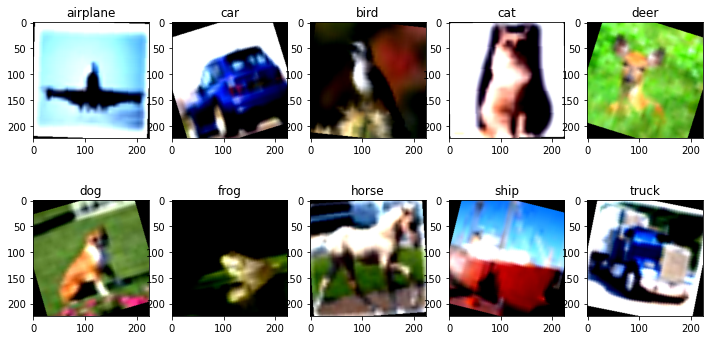

In [6]:

classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img * 0.5 + 0.5
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('on')

class_images = {class_name: None for class_name in classes}

for img, label in trainset:
    class_name = classes[label]
    if class_images[class_name] is None:
        class_images[class_name] = img
    if all(img is not None for img in class_images.values()):
        break

plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes):
    plt.subplot(2, 5, i + 1)
    imshow(class_images[class_name])
    plt.title(class_name)
plt.show()



## 2. Baseline

In [7]:
# Define accuracy function
def accuracy(output, target):
    with torch.no_grad():
        _, preds = torch.max(output, dim=1)
        correct = (preds == target).float().sum()
        acc = correct / target.size(0)
        return acc


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))



In [8]:
# Device
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [9]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


In [10]:
def fit(model, train_loader, val_loader, optimizer, patience=5, max_epochs=100):
    history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0  
    epoch = 0  

    while epoch < max_epochs:
        epoch += 1
        model.train()
        train_losses = []
        train_accs = []  

        for batch in tqdm(train_loader):
            loss, acc = model.training_step(batch)
            train_losses.append(loss.detach())
            train_accs.append(acc)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = torch.stack(train_losses).mean().item()
        avg_train_acc = torch.stack(train_accs).mean().item()
        
        result = evaluate(model, val_loader)
        val_loss = result['val_loss']
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss  
            no_improve_epochs = 0  
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} due to {patience} consecutive epochs with no improvement in val_loss.")
                break 

        result['train_loss'] = avg_train_loss
        result['train_acc'] = avg_train_acc
        model.epoch_end(epoch, result)
        history.append(result)

    final_val_acc = history[-1]['val_acc'] if history else 0
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    return history, final_val_acc


In [11]:
# tranfer dataset into cuda
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)


In [12]:
input_tensor = torch.randn(1, 3, 224, 224).to(device)

In [15]:
num_classes =10

In [83]:
# Basline- CNN
class Base_CNN(ImageClassificationBase):
    def __init__(self, num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout_prob) 
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = x.view(-1, 128 * 28 * 28)         
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                   
        x = self.fc2(x)
        return x


In [84]:
model_baseline = Base_CNN()
model_baseline = to_device(model_baseline, device)

In [85]:
summary(model_baseline, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 256]      25,690,368
           Dropout-8                  [-1, 256]               0
            Linear-9                   [-1, 10]           2,570
Total params: 25,786,186
Trainable params: 25,786,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 26.80
Params size (MB): 98.37
Estimated Total Size (MB): 125.74
---------------------------------

In [15]:
# Baseline parameters
lr = 0.0001

In [16]:
opt_baseline = optim.Adam(model_baseline.parameters(), lr)

In [17]:
history_baseline, val_acc_baseline = fit(model_baseline, train_loader, valid_loader, opt_baseline)

100%|██████████| 333/333 [00:30<00:00, 10.94it/s]


Epoch [1], train_loss: 1.7434, train_acc: 0.3725, val_loss: 1.4717, val_acc: 0.4798


100%|██████████| 333/333 [00:33<00:00, 10.06it/s]


Epoch [2], train_loss: 1.4587, train_acc: 0.4788, val_loss: 1.3423, val_acc: 0.5213


100%|██████████| 333/333 [00:32<00:00, 10.12it/s]


Epoch [3], train_loss: 1.3452, train_acc: 0.5181, val_loss: 1.2646, val_acc: 0.5516


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [4], train_loss: 1.2844, train_acc: 0.5429, val_loss: 1.2384, val_acc: 0.5611


100%|██████████| 333/333 [00:33<00:00,  9.93it/s]


Epoch [5], train_loss: 1.2362, train_acc: 0.5615, val_loss: 1.1871, val_acc: 0.5779


100%|██████████| 333/333 [00:33<00:00, 10.04it/s]


Epoch [6], train_loss: 1.1947, train_acc: 0.5781, val_loss: 1.1381, val_acc: 0.5986


100%|██████████| 333/333 [00:33<00:00, 10.04it/s]


Epoch [7], train_loss: 1.1606, train_acc: 0.5868, val_loss: 1.1175, val_acc: 0.6052


100%|██████████| 333/333 [00:32<00:00, 10.20it/s]


Epoch [8], train_loss: 1.1355, train_acc: 0.5951, val_loss: 1.1004, val_acc: 0.6097


100%|██████████| 333/333 [00:32<00:00, 10.12it/s]


Epoch [9], train_loss: 1.1080, train_acc: 0.6098, val_loss: 1.1033, val_acc: 0.6132


100%|██████████| 333/333 [00:32<00:00, 10.17it/s]


Epoch [10], train_loss: 1.0878, train_acc: 0.6156, val_loss: 1.0623, val_acc: 0.6213


100%|██████████| 333/333 [00:33<00:00,  9.82it/s]


Epoch [11], train_loss: 1.0714, train_acc: 0.6190, val_loss: 1.0764, val_acc: 0.6173


100%|██████████| 333/333 [00:32<00:00, 10.20it/s]


Epoch [12], train_loss: 1.0456, train_acc: 0.6312, val_loss: 1.0552, val_acc: 0.6279


100%|██████████| 333/333 [00:33<00:00,  9.95it/s]


Epoch [13], train_loss: 1.0247, train_acc: 0.6382, val_loss: 1.0288, val_acc: 0.6368


100%|██████████| 333/333 [00:32<00:00, 10.11it/s]


Epoch [14], train_loss: 1.0103, train_acc: 0.6437, val_loss: 1.0247, val_acc: 0.6485


100%|██████████| 333/333 [00:32<00:00, 10.10it/s]


Epoch [15], train_loss: 0.9975, train_acc: 0.6465, val_loss: 1.0030, val_acc: 0.6491


100%|██████████| 333/333 [00:33<00:00,  9.85it/s]


Epoch [16], train_loss: 0.9794, train_acc: 0.6533, val_loss: 1.0122, val_acc: 0.6454


100%|██████████| 333/333 [00:32<00:00, 10.22it/s]


Epoch [17], train_loss: 0.9694, train_acc: 0.6604, val_loss: 1.0112, val_acc: 0.6482


100%|██████████| 333/333 [00:32<00:00, 10.10it/s]


Epoch [18], train_loss: 0.9452, train_acc: 0.6663, val_loss: 0.9740, val_acc: 0.6570


100%|██████████| 333/333 [00:34<00:00,  9.77it/s]


Epoch [19], train_loss: 0.9250, train_acc: 0.6745, val_loss: 0.9796, val_acc: 0.6564


100%|██████████| 333/333 [00:33<00:00,  9.93it/s]


Epoch [20], train_loss: 0.9158, train_acc: 0.6788, val_loss: 0.9624, val_acc: 0.6646


100%|██████████| 333/333 [00:33<00:00, 10.03it/s]


Epoch [21], train_loss: 0.8965, train_acc: 0.6822, val_loss: 0.9584, val_acc: 0.6550


100%|██████████| 333/333 [00:32<00:00, 10.12it/s]


Epoch [22], train_loss: 0.8815, train_acc: 0.6881, val_loss: 0.9483, val_acc: 0.6636


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [23], train_loss: 0.8661, train_acc: 0.6924, val_loss: 0.9449, val_acc: 0.6660


100%|██████████| 333/333 [00:32<00:00, 10.16it/s]


Epoch [24], train_loss: 0.8525, train_acc: 0.6985, val_loss: 0.9437, val_acc: 0.6709


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [25], train_loss: 0.8435, train_acc: 0.7022, val_loss: 0.9258, val_acc: 0.6781


100%|██████████| 333/333 [00:33<00:00, 10.00it/s]


Epoch [26], train_loss: 0.8286, train_acc: 0.7074, val_loss: 0.9240, val_acc: 0.6739


100%|██████████| 333/333 [00:33<00:00, 10.03it/s]


Epoch [27], train_loss: 0.8118, train_acc: 0.7125, val_loss: 0.9175, val_acc: 0.6726


100%|██████████| 333/333 [00:33<00:00,  9.97it/s]


Epoch [28], train_loss: 0.7993, train_acc: 0.7149, val_loss: 0.9234, val_acc: 0.6763


100%|██████████| 333/333 [00:33<00:00,  9.91it/s]


Epoch [29], train_loss: 0.7866, train_acc: 0.7207, val_loss: 0.9261, val_acc: 0.6803


100%|██████████| 333/333 [00:33<00:00, 10.04it/s]


Epoch [30], train_loss: 0.7733, train_acc: 0.7269, val_loss: 0.9201, val_acc: 0.6737


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [31], train_loss: 0.7670, train_acc: 0.7296, val_loss: 0.9015, val_acc: 0.6831


100%|██████████| 333/333 [00:33<00:00, 10.03it/s]


Epoch [32], train_loss: 0.7546, train_acc: 0.7331, val_loss: 0.9037, val_acc: 0.6874


100%|██████████| 333/333 [00:33<00:00,  9.94it/s]


Epoch [33], train_loss: 0.7428, train_acc: 0.7382, val_loss: 0.8942, val_acc: 0.6904


100%|██████████| 333/333 [00:34<00:00,  9.64it/s]


Epoch [34], train_loss: 0.7281, train_acc: 0.7400, val_loss: 0.9154, val_acc: 0.6823


100%|██████████| 333/333 [00:35<00:00,  9.44it/s]


Epoch [35], train_loss: 0.7259, train_acc: 0.7429, val_loss: 0.9200, val_acc: 0.6841


100%|██████████| 333/333 [00:35<00:00,  9.35it/s]


Epoch [36], train_loss: 0.7263, train_acc: 0.7435, val_loss: 0.8965, val_acc: 0.6927


100%|██████████| 333/333 [00:35<00:00,  9.34it/s]


Epoch [37], train_loss: 0.6953, train_acc: 0.7497, val_loss: 0.8873, val_acc: 0.7006


100%|██████████| 333/333 [00:36<00:00,  9.20it/s]


Epoch [38], train_loss: 0.6898, train_acc: 0.7521, val_loss: 0.8827, val_acc: 0.6964


100%|██████████| 333/333 [00:33<00:00,  9.99it/s]


Epoch [39], train_loss: 0.6767, train_acc: 0.7590, val_loss: 0.8877, val_acc: 0.6995


100%|██████████| 333/333 [00:33<00:00,  9.94it/s]


Epoch [40], train_loss: 0.6708, train_acc: 0.7611, val_loss: 0.8995, val_acc: 0.7010


100%|██████████| 333/333 [00:33<00:00,  9.83it/s]


Epoch [41], train_loss: 0.6650, train_acc: 0.7638, val_loss: 0.8855, val_acc: 0.6964


100%|██████████| 333/333 [00:33<00:00, 10.02it/s]


Epoch [42], train_loss: 0.6561, train_acc: 0.7674, val_loss: 0.8694, val_acc: 0.7049


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [43], train_loss: 0.6413, train_acc: 0.7713, val_loss: 0.8804, val_acc: 0.7028


100%|██████████| 333/333 [00:33<00:00, 10.07it/s]


Epoch [44], train_loss: 0.6272, train_acc: 0.7774, val_loss: 0.9005, val_acc: 0.7006


100%|██████████| 333/333 [00:33<00:00, 10.06it/s]


Epoch [45], train_loss: 0.6208, train_acc: 0.7807, val_loss: 0.8846, val_acc: 0.7005


100%|██████████| 333/333 [00:33<00:00, 10.07it/s]


Epoch [46], train_loss: 0.6105, train_acc: 0.7812, val_loss: 0.9043, val_acc: 0.7042


100%|██████████| 333/333 [00:33<00:00,  9.91it/s]


Early stopping at epoch 47 due to 5 consecutive epochs with no improvement in val_loss.
Final Validation Accuracy: 0.7042


In [14]:
# Plot loss and accuracy 
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    plot_accuracies(history, axs[0])
    plot_losses(history, axs[1])
    plt.tight_layout()
    plt.show()

def plot_accuracies(history, ax):
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    ax.plot(train_accuracies, '-b', label='Training Accuracy')
    ax.plot(val_accuracies, '-r', label='Validation Accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.legend()
    ax.set_title('Accuracy vs. No. of epochs')

def plot_losses(history, ax):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax.plot(train_losses, '-b', label='Training Loss')
    ax.plot(val_losses, '-r', label='Validation Loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()
    ax.set_title('Loss vs. No. of epochs')


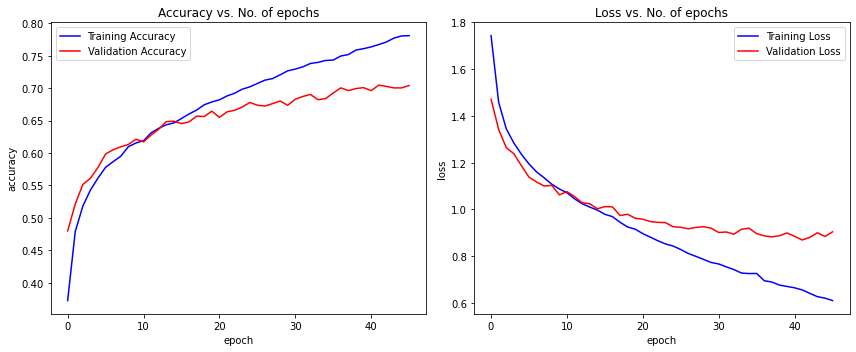

In [19]:
plot_metrics(history_baseline)

In [20]:
flop_baseline = print_model_parm_flops(model_baseline, input_tensor, detail=True)
flop_baseline

 + Number of FLOPs: 1.04G
  + Conv FLOPs: 0.99G
  + Linear FLOPs: 0.05G
  + Batch Norm FLOPs: 0.00G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


In [21]:
efficiency_baseline = val_acc_baseline / 1.04
print(f"Effiency of Baseline is {efficiency_baseline:.2f}")

Effiency of Baseline is 0.68


In [22]:
accuracies = dict()
losses = dict()
efficiencies = dict()

In [23]:
accuracies['Baseline'] = val_acc_baseline
losses['Baseline'] = [x.get('val_loss') for x in history_baseline]
efficiencies['Baseline'] = efficiency_baseline

## 3. Optimisation

### 3.1 'Transfer' learning -- ResNet

In [86]:
# Define a pre-trained new model - ResNet
class ResNetModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, X):
        return self.model(X)

In [87]:
model_res = ResNetModel(num_classes)
model_res = model_res.to(device)

In [88]:
summary(model_res, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
opt_res = optim.Adam(model_res.parameters(), lr=1e-5)


In [28]:

history_res, val_acc_res = fit(model_res, train_loader, valid_loader, opt_res)

100%|██████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [1], train_loss: 1.8177, train_acc: 0.3361, val_loss: 1.5754, val_acc: 0.4262


100%|██████████| 333/333 [00:42<00:00,  7.90it/s]


Epoch [2], train_loss: 1.4590, train_acc: 0.4735, val_loss: 1.4230, val_acc: 0.4862


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [3], train_loss: 1.3201, train_acc: 0.5252, val_loss: 1.3249, val_acc: 0.5176


100%|██████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [4], train_loss: 1.2313, train_acc: 0.5598, val_loss: 1.2322, val_acc: 0.5590


100%|██████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [5], train_loss: 1.1725, train_acc: 0.5835, val_loss: 1.2184, val_acc: 0.5675


100%|██████████| 333/333 [00:42<00:00,  7.82it/s]


Epoch [6], train_loss: 1.1228, train_acc: 0.6008, val_loss: 1.1611, val_acc: 0.5794


100%|██████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [7], train_loss: 1.0786, train_acc: 0.6212, val_loss: 1.1040, val_acc: 0.6026


100%|██████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [8], train_loss: 1.0395, train_acc: 0.6298, val_loss: 1.0660, val_acc: 0.6241


100%|██████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [9], train_loss: 1.0144, train_acc: 0.6410, val_loss: 1.0721, val_acc: 0.6168


100%|██████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [10], train_loss: 0.9744, train_acc: 0.6539, val_loss: 1.0510, val_acc: 0.6240


100%|██████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [11], train_loss: 0.9477, train_acc: 0.6636, val_loss: 1.0061, val_acc: 0.6364


100%|██████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [12], train_loss: 0.9260, train_acc: 0.6758, val_loss: 0.9932, val_acc: 0.6496


100%|██████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [13], train_loss: 0.8985, train_acc: 0.6817, val_loss: 0.9963, val_acc: 0.6456


100%|██████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [14], train_loss: 0.8791, train_acc: 0.6896, val_loss: 0.9548, val_acc: 0.6610


100%|██████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [15], train_loss: 0.8602, train_acc: 0.6966, val_loss: 0.9429, val_acc: 0.6618


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [16], train_loss: 0.8396, train_acc: 0.7046, val_loss: 0.9132, val_acc: 0.6783


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [17], train_loss: 0.8209, train_acc: 0.7115, val_loss: 0.9168, val_acc: 0.6739


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [18], train_loss: 0.8074, train_acc: 0.7158, val_loss: 0.9188, val_acc: 0.6740


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [19], train_loss: 0.7906, train_acc: 0.7223, val_loss: 0.9013, val_acc: 0.6787


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [20], train_loss: 0.7754, train_acc: 0.7275, val_loss: 0.8683, val_acc: 0.6916


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [21], train_loss: 0.7615, train_acc: 0.7348, val_loss: 0.8834, val_acc: 0.6931


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [22], train_loss: 0.7460, train_acc: 0.7409, val_loss: 0.8818, val_acc: 0.6886


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [23], train_loss: 0.7284, train_acc: 0.7458, val_loss: 0.8642, val_acc: 0.7013


100%|██████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [24], train_loss: 0.7142, train_acc: 0.7517, val_loss: 0.8405, val_acc: 0.7039


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [25], train_loss: 0.6976, train_acc: 0.7565, val_loss: 0.8553, val_acc: 0.7001


100%|██████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [26], train_loss: 0.6934, train_acc: 0.7576, val_loss: 0.8246, val_acc: 0.7068


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [27], train_loss: 0.6789, train_acc: 0.7633, val_loss: 0.8239, val_acc: 0.7144


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [28], train_loss: 0.6720, train_acc: 0.7670, val_loss: 0.8293, val_acc: 0.7100


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [29], train_loss: 0.6582, train_acc: 0.7697, val_loss: 0.8147, val_acc: 0.7162


100%|██████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [30], train_loss: 0.6471, train_acc: 0.7748, val_loss: 0.8033, val_acc: 0.7225


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [31], train_loss: 0.6401, train_acc: 0.7786, val_loss: 0.8130, val_acc: 0.7154


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [32], train_loss: 0.6227, train_acc: 0.7840, val_loss: 0.7976, val_acc: 0.7234


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [33], train_loss: 0.6123, train_acc: 0.7877, val_loss: 0.7846, val_acc: 0.7228


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [34], train_loss: 0.6069, train_acc: 0.7892, val_loss: 0.7977, val_acc: 0.7166


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [35], train_loss: 0.5926, train_acc: 0.7946, val_loss: 0.7938, val_acc: 0.7217


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [36], train_loss: 0.5839, train_acc: 0.7968, val_loss: 0.7549, val_acc: 0.7400


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [37], train_loss: 0.5687, train_acc: 0.8022, val_loss: 0.7751, val_acc: 0.7311


100%|██████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [38], train_loss: 0.5616, train_acc: 0.8055, val_loss: 0.7497, val_acc: 0.7371


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [39], train_loss: 0.5530, train_acc: 0.8106, val_loss: 0.7544, val_acc: 0.7414


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [40], train_loss: 0.5391, train_acc: 0.8150, val_loss: 0.7763, val_acc: 0.7351


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [41], train_loss: 0.5284, train_acc: 0.8171, val_loss: 0.7587, val_acc: 0.7378


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [42], train_loss: 0.5289, train_acc: 0.8154, val_loss: 0.7476, val_acc: 0.7449


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [43], train_loss: 0.5155, train_acc: 0.8227, val_loss: 0.7388, val_acc: 0.7465


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [44], train_loss: 0.5101, train_acc: 0.8248, val_loss: 0.7461, val_acc: 0.7419


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [45], train_loss: 0.5096, train_acc: 0.8242, val_loss: 0.7298, val_acc: 0.7479


100%|██████████| 333/333 [00:42<00:00,  7.82it/s]


Epoch [46], train_loss: 0.4944, train_acc: 0.8285, val_loss: 0.7659, val_acc: 0.7413


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [47], train_loss: 0.4896, train_acc: 0.8300, val_loss: 0.7453, val_acc: 0.7463


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [48], train_loss: 0.4796, train_acc: 0.8354, val_loss: 0.7223, val_acc: 0.7508


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [49], train_loss: 0.4702, train_acc: 0.8398, val_loss: 0.7336, val_acc: 0.7505


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [50], train_loss: 0.4606, train_acc: 0.8426, val_loss: 0.7187, val_acc: 0.7517


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [51], train_loss: 0.4585, train_acc: 0.8403, val_loss: 0.7213, val_acc: 0.7529


100%|██████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [52], train_loss: 0.4530, train_acc: 0.8438, val_loss: 0.7314, val_acc: 0.7578


100%|██████████| 333/333 [00:42<00:00,  7.90it/s]


Epoch [53], train_loss: 0.4408, train_acc: 0.8488, val_loss: 0.7126, val_acc: 0.7628


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [54], train_loss: 0.4312, train_acc: 0.8510, val_loss: 0.7218, val_acc: 0.7572


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [55], train_loss: 0.4259, train_acc: 0.8554, val_loss: 0.6986, val_acc: 0.7667


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [56], train_loss: 0.4182, train_acc: 0.8571, val_loss: 0.6998, val_acc: 0.7588


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [57], train_loss: 0.4125, train_acc: 0.8586, val_loss: 0.7060, val_acc: 0.7620


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [58], train_loss: 0.4054, train_acc: 0.8633, val_loss: 0.7085, val_acc: 0.7666


100%|██████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [59], train_loss: 0.4038, train_acc: 0.8624, val_loss: 0.7226, val_acc: 0.7606


100%|██████████| 333/333 [00:42<00:00,  7.87it/s]


Early stopping at epoch 60 due to 5 consecutive epochs with no improvement in val_loss.
Final Validation Accuracy: 0.7606


In [29]:
# Output the FLOPs of the model
flop_res = print_model_parm_flops(model_res, input_tensor, detail=True)
flop_res

 + Number of FLOPs: 3.59G
  + Conv FLOPs: 3.57G
  + Linear FLOPs: 0.00G
  + Batch Norm FLOPs: 0.01G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


In [30]:
efficiency_res = val_acc_res / 3.59
print(f"[ResNet]  Effiency: {efficiency_res:.2f}")

[ResNet]  Effiency: 0.21


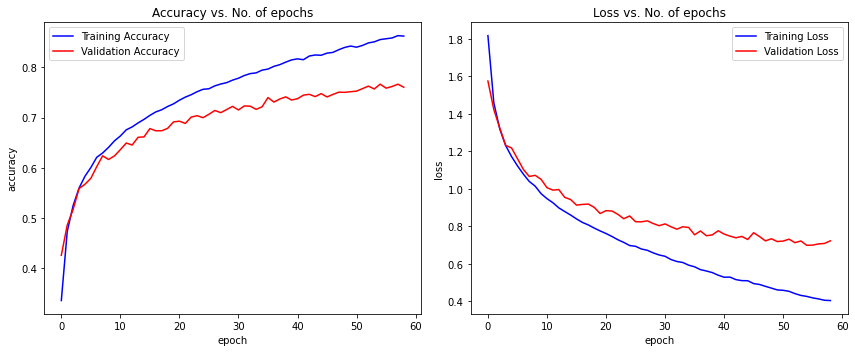

In [31]:
plot_metrics(history_res)

In [32]:
accuracies['ResNet'] = val_acc_res
losses['ResNet'] = [x.get('val_loss') for x in history_res]
efficiencies['ResNet'] = efficiency_res

### 3.2 'Transfer' learning -- MobileNet

In [89]:
# Define a new pre-trained model - MobileNet
class MobileNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
    
    def forward(self, X):
        return self.model(X)

In [90]:
model_mob = MobileNet(num_classes)
model_mob = model_mob.to(device)

In [91]:
summary(model_mob, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [35]:
opt_mob = optim.Adam(model_mob.parameters(), lr=1e-5)


In [36]:
history_mob, val_acc_mob = fit(model_mob, train_loader, valid_loader, opt_mob)

100%|██████████| 333/333 [01:06<00:00,  5.01it/s]


Epoch [1], train_loss: 2.2532, train_acc: 0.1437, val_loss: 2.1889, val_acc: 0.1853


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [2], train_loss: 2.0779, train_acc: 0.2185, val_loss: 1.9768, val_acc: 0.2511


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [3], train_loss: 1.9305, train_acc: 0.2662, val_loss: 1.8721, val_acc: 0.2979


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [4], train_loss: 1.8438, train_acc: 0.3016, val_loss: 1.8005, val_acc: 0.3281


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [5], train_loss: 1.7724, train_acc: 0.3308, val_loss: 1.7309, val_acc: 0.3560


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [6], train_loss: 1.7113, train_acc: 0.3580, val_loss: 1.6840, val_acc: 0.3724


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [7], train_loss: 1.6665, train_acc: 0.3717, val_loss: 1.6429, val_acc: 0.3873


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [8], train_loss: 1.6342, train_acc: 0.3867, val_loss: 1.6101, val_acc: 0.4010


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [9], train_loss: 1.6088, train_acc: 0.3995, val_loss: 1.5895, val_acc: 0.4118


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [10], train_loss: 1.5781, train_acc: 0.4119, val_loss: 1.5696, val_acc: 0.4149


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [11], train_loss: 1.5566, train_acc: 0.4212, val_loss: 1.5451, val_acc: 0.4303


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [12], train_loss: 1.5317, train_acc: 0.4328, val_loss: 1.5172, val_acc: 0.4384


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [13], train_loss: 1.5143, train_acc: 0.4408, val_loss: 1.5166, val_acc: 0.4439


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [14], train_loss: 1.4964, train_acc: 0.4491, val_loss: 1.4870, val_acc: 0.4553


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [15], train_loss: 1.4713, train_acc: 0.4584, val_loss: 1.4602, val_acc: 0.4605


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [16], train_loss: 1.4579, train_acc: 0.4642, val_loss: 1.4526, val_acc: 0.4697


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [17], train_loss: 1.4406, train_acc: 0.4682, val_loss: 1.4336, val_acc: 0.4733


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [18], train_loss: 1.4261, train_acc: 0.4769, val_loss: 1.4248, val_acc: 0.4780


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [19], train_loss: 1.4128, train_acc: 0.4812, val_loss: 1.4113, val_acc: 0.4844


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [20], train_loss: 1.3984, train_acc: 0.4898, val_loss: 1.3926, val_acc: 0.4919


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [21], train_loss: 1.3826, train_acc: 0.4922, val_loss: 1.3790, val_acc: 0.4939


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [22], train_loss: 1.3765, train_acc: 0.4984, val_loss: 1.3671, val_acc: 0.5033


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [23], train_loss: 1.3637, train_acc: 0.5038, val_loss: 1.3597, val_acc: 0.5076


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [24], train_loss: 1.3462, train_acc: 0.5119, val_loss: 1.3520, val_acc: 0.5077


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [25], train_loss: 1.3334, train_acc: 0.5140, val_loss: 1.3513, val_acc: 0.5065


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [26], train_loss: 1.3250, train_acc: 0.5186, val_loss: 1.3257, val_acc: 0.5246


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [27], train_loss: 1.3107, train_acc: 0.5224, val_loss: 1.3181, val_acc: 0.5215


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [28], train_loss: 1.2983, train_acc: 0.5279, val_loss: 1.3067, val_acc: 0.5267


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [29], train_loss: 1.2840, train_acc: 0.5379, val_loss: 1.3008, val_acc: 0.5319


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [30], train_loss: 1.2747, train_acc: 0.5360, val_loss: 1.2851, val_acc: 0.5385


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [31], train_loss: 1.2656, train_acc: 0.5411, val_loss: 1.2818, val_acc: 0.5328


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [32], train_loss: 1.2546, train_acc: 0.5461, val_loss: 1.2813, val_acc: 0.5337


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [33], train_loss: 1.2395, train_acc: 0.5496, val_loss: 1.2567, val_acc: 0.5452


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [34], train_loss: 1.2317, train_acc: 0.5515, val_loss: 1.2433, val_acc: 0.5450


100%|██████████| 333/333 [01:06<00:00,  5.01it/s]


Epoch [35], train_loss: 1.2184, train_acc: 0.5614, val_loss: 1.2352, val_acc: 0.5541


100%|██████████| 333/333 [01:06<00:00,  5.00it/s]


Epoch [36], train_loss: 1.2130, train_acc: 0.5627, val_loss: 1.2196, val_acc: 0.5585


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [37], train_loss: 1.2037, train_acc: 0.5655, val_loss: 1.2329, val_acc: 0.5550


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [38], train_loss: 1.1956, train_acc: 0.5709, val_loss: 1.2203, val_acc: 0.5582


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [39], train_loss: 1.1841, train_acc: 0.5728, val_loss: 1.1984, val_acc: 0.5680


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [40], train_loss: 1.1796, train_acc: 0.5784, val_loss: 1.1938, val_acc: 0.5686


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [41], train_loss: 1.1654, train_acc: 0.5795, val_loss: 1.1893, val_acc: 0.5690


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [42], train_loss: 1.1537, train_acc: 0.5841, val_loss: 1.1773, val_acc: 0.5720


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [43], train_loss: 1.1426, train_acc: 0.5885, val_loss: 1.1798, val_acc: 0.5728


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [44], train_loss: 1.1378, train_acc: 0.5898, val_loss: 1.1602, val_acc: 0.5841


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [45], train_loss: 1.1309, train_acc: 0.5934, val_loss: 1.1487, val_acc: 0.5855


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [46], train_loss: 1.1139, train_acc: 0.5980, val_loss: 1.1414, val_acc: 0.5882


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [47], train_loss: 1.1076, train_acc: 0.6032, val_loss: 1.1258, val_acc: 0.5943


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [48], train_loss: 1.0991, train_acc: 0.6086, val_loss: 1.1378, val_acc: 0.5910


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [49], train_loss: 1.0854, train_acc: 0.6109, val_loss: 1.1232, val_acc: 0.5966


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [50], train_loss: 1.0858, train_acc: 0.6132, val_loss: 1.1136, val_acc: 0.5987


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [51], train_loss: 1.0724, train_acc: 0.6184, val_loss: 1.0983, val_acc: 0.6023


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [52], train_loss: 1.0628, train_acc: 0.6216, val_loss: 1.1048, val_acc: 0.6097


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [53], train_loss: 1.0639, train_acc: 0.6178, val_loss: 1.0960, val_acc: 0.6072


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [54], train_loss: 1.0504, train_acc: 0.6262, val_loss: 1.0773, val_acc: 0.6103


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [55], train_loss: 1.0390, train_acc: 0.6269, val_loss: 1.0846, val_acc: 0.6147


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [56], train_loss: 1.0270, train_acc: 0.6348, val_loss: 1.0788, val_acc: 0.6153


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [57], train_loss: 1.0200, train_acc: 0.6361, val_loss: 1.0537, val_acc: 0.6172


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [58], train_loss: 1.0161, train_acc: 0.6382, val_loss: 1.0546, val_acc: 0.6150


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [59], train_loss: 1.0047, train_acc: 0.6436, val_loss: 1.0458, val_acc: 0.6210


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [60], train_loss: 0.9995, train_acc: 0.6418, val_loss: 1.0536, val_acc: 0.6215


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [61], train_loss: 0.9987, train_acc: 0.6444, val_loss: 1.0422, val_acc: 0.6252


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [62], train_loss: 0.9885, train_acc: 0.6498, val_loss: 1.0489, val_acc: 0.6232


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [63], train_loss: 0.9759, train_acc: 0.6534, val_loss: 1.0287, val_acc: 0.6321


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [64], train_loss: 0.9733, train_acc: 0.6521, val_loss: 1.0434, val_acc: 0.6238


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [65], train_loss: 0.9671, train_acc: 0.6568, val_loss: 1.0297, val_acc: 0.6343


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [66], train_loss: 0.9612, train_acc: 0.6582, val_loss: 1.0058, val_acc: 0.6379


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [67], train_loss: 0.9494, train_acc: 0.6622, val_loss: 1.0077, val_acc: 0.6397


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [68], train_loss: 0.9406, train_acc: 0.6668, val_loss: 1.0012, val_acc: 0.6442


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [69], train_loss: 0.9339, train_acc: 0.6670, val_loss: 0.9922, val_acc: 0.6447


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [70], train_loss: 0.9262, train_acc: 0.6727, val_loss: 1.0018, val_acc: 0.6425


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [71], train_loss: 0.9258, train_acc: 0.6713, val_loss: 0.9870, val_acc: 0.6479


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [72], train_loss: 0.9186, train_acc: 0.6722, val_loss: 0.9703, val_acc: 0.6543


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [73], train_loss: 0.9161, train_acc: 0.6754, val_loss: 0.9817, val_acc: 0.6477


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [74], train_loss: 0.9071, train_acc: 0.6807, val_loss: 0.9767, val_acc: 0.6546


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [75], train_loss: 0.8974, train_acc: 0.6812, val_loss: 0.9622, val_acc: 0.6555


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [76], train_loss: 0.8886, train_acc: 0.6854, val_loss: 0.9610, val_acc: 0.6532


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [77], train_loss: 0.8927, train_acc: 0.6861, val_loss: 0.9562, val_acc: 0.6608


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [78], train_loss: 0.8781, train_acc: 0.6890, val_loss: 0.9506, val_acc: 0.6608


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [79], train_loss: 0.8705, train_acc: 0.6905, val_loss: 0.9585, val_acc: 0.6607


100%|██████████| 333/333 [01:06<00:00,  5.01it/s]


Epoch [80], train_loss: 0.8746, train_acc: 0.6890, val_loss: 0.9441, val_acc: 0.6659


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [81], train_loss: 0.8585, train_acc: 0.6945, val_loss: 0.9353, val_acc: 0.6721


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [82], train_loss: 0.8548, train_acc: 0.6954, val_loss: 0.9314, val_acc: 0.6707


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [83], train_loss: 0.8478, train_acc: 0.6986, val_loss: 0.9339, val_acc: 0.6712


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [84], train_loss: 0.8449, train_acc: 0.6991, val_loss: 0.9379, val_acc: 0.6616


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [85], train_loss: 0.8384, train_acc: 0.7029, val_loss: 0.9171, val_acc: 0.6784


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [86], train_loss: 0.8340, train_acc: 0.7056, val_loss: 0.9286, val_acc: 0.6719


100%|██████████| 333/333 [01:06<00:00,  5.04it/s]


Epoch [87], train_loss: 0.8283, train_acc: 0.7061, val_loss: 0.9034, val_acc: 0.6822


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [88], train_loss: 0.8270, train_acc: 0.7092, val_loss: 0.9151, val_acc: 0.6806


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [89], train_loss: 0.8206, train_acc: 0.7100, val_loss: 0.9144, val_acc: 0.6708


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [90], train_loss: 0.8179, train_acc: 0.7119, val_loss: 0.9097, val_acc: 0.6833


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [91], train_loss: 0.8143, train_acc: 0.7129, val_loss: 0.9159, val_acc: 0.6767


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [92], train_loss: 0.8005, train_acc: 0.7184, val_loss: 0.8981, val_acc: 0.6819


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [93], train_loss: 0.7945, train_acc: 0.7216, val_loss: 0.8985, val_acc: 0.6826


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [94], train_loss: 0.7894, train_acc: 0.7216, val_loss: 0.9016, val_acc: 0.6831


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [95], train_loss: 0.7883, train_acc: 0.7215, val_loss: 0.8918, val_acc: 0.6892


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [96], train_loss: 0.7766, train_acc: 0.7252, val_loss: 0.8923, val_acc: 0.6880


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [97], train_loss: 0.7818, train_acc: 0.7238, val_loss: 0.8741, val_acc: 0.6938


100%|██████████| 333/333 [01:06<00:00,  5.03it/s]


Epoch [98], train_loss: 0.7710, train_acc: 0.7285, val_loss: 0.8865, val_acc: 0.6859


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [99], train_loss: 0.7714, train_acc: 0.7279, val_loss: 0.8796, val_acc: 0.6912


100%|██████████| 333/333 [01:06<00:00,  5.02it/s]


Epoch [100], train_loss: 0.7619, train_acc: 0.7319, val_loss: 0.8917, val_acc: 0.6892
Final Validation Accuracy: 0.6892


In [37]:
flop_mob = print_model_parm_flops(model_mob, input_tensor, detail=True)
flop_mob

 + Number of FLOPs: 0.60G
  + Conv FLOPs: 0.57G
  + Linear FLOPs: 0.00G
  + Batch Norm FLOPs: 0.03G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


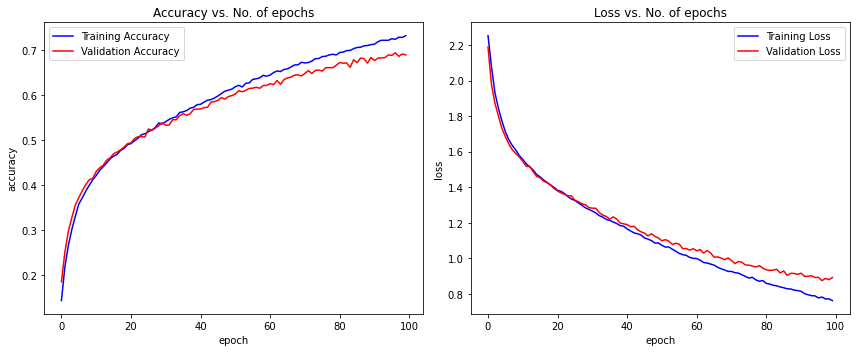

In [38]:
plot_metrics(history_mob)

In [39]:
efficiency_mob = val_acc_mob / 0.60
print(f"[MobileNet]  Effiency: {efficiency_mob:.2f}")

[MobileNet]  Effiency: 1.15


In [40]:
accuracies['MobileNet'] = val_acc_mob
losses['MobileNet'] = [x.get('val_loss') for x in history_mob]
efficiencies['MobileNet'] = efficiency_mob

### 3.3 'Transfer' learning -- AlexNet

In [92]:

class AlexNetModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.alexnet(pretrained=False)
        
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)

    def forward(self, X):
        return self.model(X)


In [93]:
model_alex = AlexNetModel(num_classes)
model_alex = model_alex.to(device)

In [94]:
summary(model_alex, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [43]:
opt_alex = optim.Adam(model_alex.parameters(), lr=1e-5)


In [44]:
history_alex, val_acc_alex = fit(model_alex, train_loader, valid_loader, opt_alex)

100%|██████████| 333/333 [00:33<00:00,  9.83it/s]


Epoch [1], train_loss: 1.9781, train_acc: 0.2725, val_loss: 1.7699, val_acc: 0.3513


100%|██████████| 333/333 [00:33<00:00,  9.88it/s]


Epoch [2], train_loss: 1.6761, train_acc: 0.3864, val_loss: 1.7336, val_acc: 0.3828


100%|██████████| 333/333 [00:33<00:00,  9.91it/s]


Epoch [3], train_loss: 1.5598, train_acc: 0.4289, val_loss: 1.5550, val_acc: 0.4482


100%|██████████| 333/333 [00:33<00:00,  9.86it/s]


Epoch [4], train_loss: 1.4876, train_acc: 0.4609, val_loss: 1.4948, val_acc: 0.4777


100%|██████████| 333/333 [00:33<00:00,  9.92it/s]


Epoch [5], train_loss: 1.4319, train_acc: 0.4827, val_loss: 1.4055, val_acc: 0.4935


100%|██████████| 333/333 [00:35<00:00,  9.26it/s]


Epoch [6], train_loss: 1.3837, train_acc: 0.4996, val_loss: 1.4380, val_acc: 0.4820


100%|██████████| 333/333 [00:34<00:00,  9.71it/s]


Epoch [7], train_loss: 1.3447, train_acc: 0.5151, val_loss: 1.3574, val_acc: 0.5252


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [8], train_loss: 1.3054, train_acc: 0.5313, val_loss: 1.3031, val_acc: 0.5379


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [9], train_loss: 1.2792, train_acc: 0.5421, val_loss: 1.2858, val_acc: 0.5396


100%|██████████| 333/333 [00:34<00:00,  9.76it/s]


Epoch [10], train_loss: 1.2410, train_acc: 0.5588, val_loss: 1.4341, val_acc: 0.5060


100%|██████████| 333/333 [00:34<00:00,  9.67it/s]


Epoch [11], train_loss: 1.2115, train_acc: 0.5700, val_loss: 1.2709, val_acc: 0.5485


100%|██████████| 333/333 [00:33<00:00,  9.97it/s]


Epoch [12], train_loss: 1.1786, train_acc: 0.5806, val_loss: 1.2032, val_acc: 0.5748


100%|██████████| 333/333 [00:34<00:00,  9.67it/s]


Epoch [13], train_loss: 1.1532, train_acc: 0.5923, val_loss: 1.1283, val_acc: 0.6009


100%|██████████| 333/333 [00:33<00:00,  9.87it/s]


Epoch [14], train_loss: 1.1254, train_acc: 0.6017, val_loss: 1.1221, val_acc: 0.6012


100%|██████████| 333/333 [00:33<00:00,  9.87it/s]


Epoch [15], train_loss: 1.1087, train_acc: 0.6087, val_loss: 1.1388, val_acc: 0.6003


100%|██████████| 333/333 [00:33<00:00,  9.92it/s]


Epoch [16], train_loss: 1.0820, train_acc: 0.6177, val_loss: 1.0630, val_acc: 0.6252


100%|██████████| 333/333 [00:33<00:00,  9.89it/s]


Epoch [17], train_loss: 1.0703, train_acc: 0.6241, val_loss: 1.0660, val_acc: 0.6207


100%|██████████| 333/333 [00:33<00:00, 10.03it/s]


Epoch [18], train_loss: 1.0418, train_acc: 0.6347, val_loss: 1.0716, val_acc: 0.6282


100%|██████████| 333/333 [00:33<00:00, 10.06it/s]


Epoch [19], train_loss: 1.0271, train_acc: 0.6373, val_loss: 1.1018, val_acc: 0.6193


100%|██████████| 333/333 [00:33<00:00,  9.93it/s]


Epoch [20], train_loss: 1.0162, train_acc: 0.6419, val_loss: 1.0021, val_acc: 0.6471


100%|██████████| 333/333 [00:33<00:00,  9.88it/s]


Epoch [21], train_loss: 0.9959, train_acc: 0.6501, val_loss: 0.9822, val_acc: 0.6551


100%|██████████| 333/333 [00:32<00:00, 10.10it/s]


Epoch [22], train_loss: 0.9765, train_acc: 0.6565, val_loss: 0.9714, val_acc: 0.6580


100%|██████████| 333/333 [00:33<00:00, 10.08it/s]


Epoch [23], train_loss: 0.9620, train_acc: 0.6615, val_loss: 0.9864, val_acc: 0.6550


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [24], train_loss: 0.9524, train_acc: 0.6673, val_loss: 0.9450, val_acc: 0.6666


100%|██████████| 333/333 [00:32<00:00, 10.12it/s]


Epoch [25], train_loss: 0.9295, train_acc: 0.6734, val_loss: 1.0913, val_acc: 0.6202


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [26], train_loss: 0.9303, train_acc: 0.6735, val_loss: 0.9258, val_acc: 0.6767


100%|██████████| 333/333 [00:33<00:00,  9.91it/s]


Epoch [27], train_loss: 0.9035, train_acc: 0.6839, val_loss: 0.9592, val_acc: 0.6653


100%|██████████| 333/333 [00:33<00:00,  9.89it/s]


Epoch [28], train_loss: 0.8928, train_acc: 0.6853, val_loss: 0.9110, val_acc: 0.6789


100%|██████████| 333/333 [00:33<00:00,  9.90it/s]


Epoch [29], train_loss: 0.8814, train_acc: 0.6917, val_loss: 0.8917, val_acc: 0.6904


100%|██████████| 333/333 [00:32<00:00, 10.26it/s]


Epoch [30], train_loss: 0.8691, train_acc: 0.6955, val_loss: 0.8940, val_acc: 0.6866


100%|██████████| 333/333 [00:33<00:00,  9.99it/s]


Epoch [31], train_loss: 0.8537, train_acc: 0.7004, val_loss: 0.8928, val_acc: 0.6902


100%|██████████| 333/333 [00:33<00:00, 10.08it/s]


Epoch [32], train_loss: 0.8448, train_acc: 0.7055, val_loss: 0.8584, val_acc: 0.7002


100%|██████████| 333/333 [00:34<00:00,  9.70it/s]


Epoch [33], train_loss: 0.8297, train_acc: 0.7089, val_loss: 0.8607, val_acc: 0.6965


100%|██████████| 333/333 [00:33<00:00,  9.93it/s]


Epoch [34], train_loss: 0.8318, train_acc: 0.7111, val_loss: 0.8440, val_acc: 0.7069


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [35], train_loss: 0.8115, train_acc: 0.7144, val_loss: 0.8597, val_acc: 0.6981


100%|██████████| 333/333 [00:33<00:00,  9.87it/s]


Epoch [36], train_loss: 0.8021, train_acc: 0.7178, val_loss: 0.8717, val_acc: 0.6976


100%|██████████| 333/333 [00:33<00:00, 10.06it/s]


Epoch [37], train_loss: 0.7935, train_acc: 0.7218, val_loss: 0.8126, val_acc: 0.7195


100%|██████████| 333/333 [00:33<00:00,  9.92it/s]


Epoch [38], train_loss: 0.7792, train_acc: 0.7235, val_loss: 0.8043, val_acc: 0.7165


100%|██████████| 333/333 [00:33<00:00,  9.95it/s]


Epoch [39], train_loss: 0.7760, train_acc: 0.7294, val_loss: 0.8356, val_acc: 0.7142


100%|██████████| 333/333 [00:34<00:00,  9.78it/s]


Epoch [40], train_loss: 0.7588, train_acc: 0.7366, val_loss: 0.8068, val_acc: 0.7224


100%|██████████| 333/333 [00:34<00:00,  9.75it/s]


Epoch [41], train_loss: 0.7567, train_acc: 0.7376, val_loss: 0.7851, val_acc: 0.7305


100%|██████████| 333/333 [00:33<00:00,  9.83it/s]


Epoch [42], train_loss: 0.7530, train_acc: 0.7384, val_loss: 0.8036, val_acc: 0.7258


100%|██████████| 333/333 [00:32<00:00, 10.11it/s]


Epoch [43], train_loss: 0.7368, train_acc: 0.7437, val_loss: 0.7718, val_acc: 0.7346


100%|██████████| 333/333 [00:34<00:00,  9.73it/s]


Epoch [44], train_loss: 0.7217, train_acc: 0.7461, val_loss: 0.7477, val_acc: 0.7440


100%|██████████| 333/333 [00:34<00:00,  9.69it/s]


Epoch [45], train_loss: 0.7100, train_acc: 0.7518, val_loss: 0.7973, val_acc: 0.7244


100%|██████████| 333/333 [00:33<00:00,  9.88it/s]


Epoch [46], train_loss: 0.7006, train_acc: 0.7540, val_loss: 0.7839, val_acc: 0.7361


100%|██████████| 333/333 [00:33<00:00,  9.95it/s]


Epoch [47], train_loss: 0.6953, train_acc: 0.7551, val_loss: 0.7379, val_acc: 0.7469


100%|██████████| 333/333 [00:33<00:00,  9.99it/s]


Epoch [48], train_loss: 0.6896, train_acc: 0.7569, val_loss: 0.7432, val_acc: 0.7382


100%|██████████| 333/333 [00:33<00:00,  9.87it/s]


Epoch [49], train_loss: 0.6808, train_acc: 0.7606, val_loss: 0.7444, val_acc: 0.7442


100%|██████████| 333/333 [00:33<00:00,  9.81it/s]


Epoch [50], train_loss: 0.6725, train_acc: 0.7636, val_loss: 0.7225, val_acc: 0.7502


100%|██████████| 333/333 [00:33<00:00,  9.94it/s]


Epoch [51], train_loss: 0.6594, train_acc: 0.7699, val_loss: 0.7362, val_acc: 0.7530


100%|██████████| 333/333 [00:33<00:00,  9.99it/s]


Epoch [52], train_loss: 0.6505, train_acc: 0.7739, val_loss: 0.7324, val_acc: 0.7490


100%|██████████| 333/333 [00:33<00:00,  9.81it/s]


Epoch [53], train_loss: 0.6430, train_acc: 0.7754, val_loss: 0.7278, val_acc: 0.7464


100%|██████████| 333/333 [00:33<00:00,  9.94it/s]


Epoch [54], train_loss: 0.6347, train_acc: 0.7767, val_loss: 0.7106, val_acc: 0.7517


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [55], train_loss: 0.6312, train_acc: 0.7787, val_loss: 0.6863, val_acc: 0.7614


100%|██████████| 333/333 [00:33<00:00,  9.90it/s]


Epoch [56], train_loss: 0.6200, train_acc: 0.7826, val_loss: 0.6930, val_acc: 0.7628


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [57], train_loss: 0.6127, train_acc: 0.7842, val_loss: 0.6849, val_acc: 0.7677


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [58], train_loss: 0.6041, train_acc: 0.7884, val_loss: 0.6671, val_acc: 0.7736


100%|██████████| 333/333 [00:33<00:00,  9.93it/s]


Epoch [59], train_loss: 0.5959, train_acc: 0.7923, val_loss: 0.6642, val_acc: 0.7773


100%|██████████| 333/333 [00:33<00:00, 10.06it/s]


Epoch [60], train_loss: 0.5920, train_acc: 0.7904, val_loss: 0.6567, val_acc: 0.7704


100%|██████████| 333/333 [00:33<00:00, 10.04it/s]


Epoch [61], train_loss: 0.5844, train_acc: 0.7944, val_loss: 0.6946, val_acc: 0.7664


100%|██████████| 333/333 [00:33<00:00,  9.97it/s]


Epoch [62], train_loss: 0.5796, train_acc: 0.7992, val_loss: 0.6713, val_acc: 0.7702


100%|██████████| 333/333 [00:33<00:00,  9.99it/s]


Epoch [63], train_loss: 0.5637, train_acc: 0.8027, val_loss: 0.6828, val_acc: 0.7614


100%|██████████| 333/333 [00:33<00:00,  9.84it/s]


Epoch [64], train_loss: 0.5550, train_acc: 0.8060, val_loss: 0.6438, val_acc: 0.7798


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [65], train_loss: 0.5540, train_acc: 0.8046, val_loss: 0.6421, val_acc: 0.7811


100%|██████████| 333/333 [00:33<00:00,  9.92it/s]


Epoch [66], train_loss: 0.5511, train_acc: 0.8062, val_loss: 0.6894, val_acc: 0.7579


100%|██████████| 333/333 [00:33<00:00,  9.95it/s]


Epoch [67], train_loss: 0.5458, train_acc: 0.8075, val_loss: 0.6446, val_acc: 0.7801


100%|██████████| 333/333 [00:33<00:00, 10.05it/s]


Epoch [68], train_loss: 0.5358, train_acc: 0.8132, val_loss: 0.6473, val_acc: 0.7807


100%|██████████| 333/333 [00:33<00:00,  9.86it/s]


Epoch [69], train_loss: 0.5224, train_acc: 0.8150, val_loss: 0.6248, val_acc: 0.7876


100%|██████████| 333/333 [00:33<00:00,  9.96it/s]


Epoch [70], train_loss: 0.5242, train_acc: 0.8163, val_loss: 0.6441, val_acc: 0.7750


100%|██████████| 333/333 [00:33<00:00,  9.88it/s]


Epoch [71], train_loss: 0.5145, train_acc: 0.8207, val_loss: 0.6211, val_acc: 0.7852


100%|██████████| 333/333 [00:33<00:00, 10.05it/s]


Epoch [72], train_loss: 0.5073, train_acc: 0.8214, val_loss: 0.6124, val_acc: 0.7875


100%|██████████| 333/333 [00:33<00:00,  9.85it/s]


Epoch [73], train_loss: 0.5064, train_acc: 0.8220, val_loss: 0.6222, val_acc: 0.7877


100%|██████████| 333/333 [00:33<00:00, 10.08it/s]


Epoch [74], train_loss: 0.4964, train_acc: 0.8242, val_loss: 0.6122, val_acc: 0.7909


100%|██████████| 333/333 [00:33<00:00,  9.99it/s]


Epoch [75], train_loss: 0.4926, train_acc: 0.8271, val_loss: 0.6127, val_acc: 0.7870


100%|██████████| 333/333 [00:33<00:00,  9.91it/s]


Epoch [76], train_loss: 0.4871, train_acc: 0.8298, val_loss: 0.6016, val_acc: 0.7930


100%|██████████| 333/333 [00:33<00:00,  9.91it/s]


Epoch [77], train_loss: 0.4772, train_acc: 0.8296, val_loss: 0.6109, val_acc: 0.7919


100%|██████████| 333/333 [00:33<00:00,  9.98it/s]


Epoch [78], train_loss: 0.4730, train_acc: 0.8345, val_loss: 0.5931, val_acc: 0.7955


100%|██████████| 333/333 [00:33<00:00,  9.92it/s]


Epoch [79], train_loss: 0.4678, train_acc: 0.8359, val_loss: 0.5963, val_acc: 0.7933


100%|██████████| 333/333 [00:33<00:00,  9.80it/s]


Epoch [80], train_loss: 0.4651, train_acc: 0.8382, val_loss: 0.5988, val_acc: 0.7969


100%|██████████| 333/333 [00:33<00:00,  9.90it/s]


Epoch [81], train_loss: 0.4588, train_acc: 0.8388, val_loss: 0.6119, val_acc: 0.7899


100%|██████████| 333/333 [00:33<00:00,  9.87it/s]


Epoch [82], train_loss: 0.4510, train_acc: 0.8433, val_loss: 0.5834, val_acc: 0.8005


100%|██████████| 333/333 [00:33<00:00,  9.85it/s]


Epoch [83], train_loss: 0.4480, train_acc: 0.8420, val_loss: 0.5922, val_acc: 0.8011


100%|██████████| 333/333 [00:33<00:00,  9.83it/s]


Epoch [84], train_loss: 0.4435, train_acc: 0.8444, val_loss: 0.5917, val_acc: 0.7970


100%|██████████| 333/333 [00:33<00:00,  9.82it/s]


Epoch [85], train_loss: 0.4407, train_acc: 0.8458, val_loss: 0.5788, val_acc: 0.8063


100%|██████████| 333/333 [00:33<00:00, 10.01it/s]


Epoch [86], train_loss: 0.4338, train_acc: 0.8483, val_loss: 0.5810, val_acc: 0.8059


100%|██████████| 333/333 [00:34<00:00,  9.56it/s]


Epoch [87], train_loss: 0.4253, train_acc: 0.8489, val_loss: 0.5677, val_acc: 0.8055


100%|██████████| 333/333 [00:33<00:00,  9.88it/s]


Epoch [88], train_loss: 0.4303, train_acc: 0.8501, val_loss: 0.5963, val_acc: 0.7963


100%|██████████| 333/333 [00:33<00:00,  9.87it/s]


Epoch [89], train_loss: 0.4351, train_acc: 0.8494, val_loss: 0.5794, val_acc: 0.8057


100%|██████████| 333/333 [00:34<00:00,  9.68it/s]


Epoch [90], train_loss: 0.4165, train_acc: 0.8544, val_loss: 0.5780, val_acc: 0.8056


100%|██████████| 333/333 [00:33<00:00,  9.96it/s]


Epoch [91], train_loss: 0.4026, train_acc: 0.8577, val_loss: 0.5739, val_acc: 0.8040


100%|██████████| 333/333 [00:33<00:00, 10.02it/s]


Epoch [92], train_loss: 0.3959, train_acc: 0.8595, val_loss: 0.5613, val_acc: 0.8067


100%|██████████| 333/333 [00:33<00:00, 10.04it/s]


Epoch [93], train_loss: 0.3970, train_acc: 0.8601, val_loss: 0.5678, val_acc: 0.8100


100%|██████████| 333/333 [00:33<00:00,  9.90it/s]


Epoch [94], train_loss: 0.3981, train_acc: 0.8595, val_loss: 0.5565, val_acc: 0.8126


100%|██████████| 333/333 [00:33<00:00,  9.88it/s]


Epoch [95], train_loss: 0.3860, train_acc: 0.8642, val_loss: 0.5781, val_acc: 0.8090


100%|██████████| 333/333 [00:33<00:00,  9.94it/s]


Epoch [96], train_loss: 0.3827, train_acc: 0.8652, val_loss: 0.5651, val_acc: 0.8087


100%|██████████| 333/333 [00:33<00:00,  9.90it/s]


Epoch [97], train_loss: 0.3801, train_acc: 0.8670, val_loss: 0.5956, val_acc: 0.7979


100%|██████████| 333/333 [00:33<00:00,  9.89it/s]


Epoch [98], train_loss: 0.3760, train_acc: 0.8687, val_loss: 0.5457, val_acc: 0.8194


100%|██████████| 333/333 [00:33<00:00, 10.04it/s]


Epoch [99], train_loss: 0.3699, train_acc: 0.8701, val_loss: 0.5612, val_acc: 0.8142


100%|██████████| 333/333 [00:33<00:00,  9.92it/s]


Epoch [100], train_loss: 0.3711, train_acc: 0.8686, val_loss: 0.5680, val_acc: 0.8076
Final Validation Accuracy: 0.8076


In [45]:
flop_alex = print_model_parm_flops(model_alex, input_tensor, detail=True)
flop_alex

 + Number of FLOPs: 1.39G
  + Conv FLOPs: 1.28G
  + Linear FLOPs: 0.11G
  + Batch Norm FLOPs: 0.00G
  + Relu FLOPs: 0.00G
  + Pooling FLOPs: 0.00G


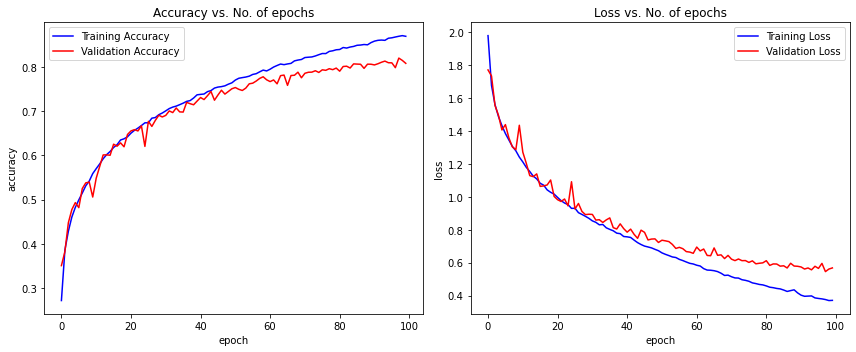

In [46]:
plot_metrics(history_alex)

In [47]:
efficiency_alex = val_acc_alex / 1.39
print(f"[Alex]  Effiency: {efficiency_alex:.2f}")

[Alex]  Effiency: 0.58


In [48]:
accuracies['AlexNet'] = val_acc_alex
losses['AlexNet'] = [x.get('val_loss') for x in history_alex]
efficiencies['ALexNet'] = efficiency_alex

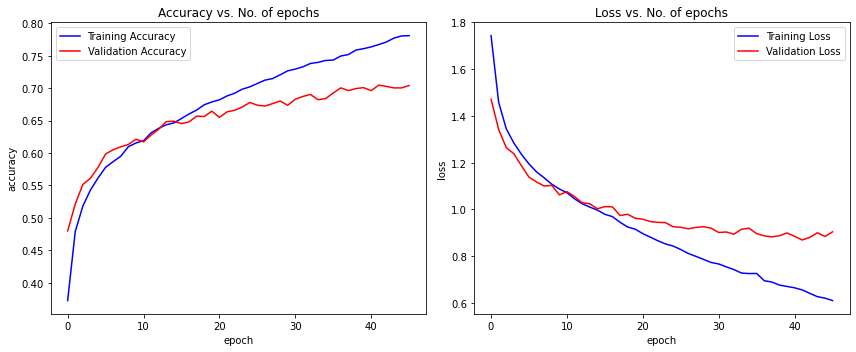

In [49]:
plot_metrics(history_baseline)

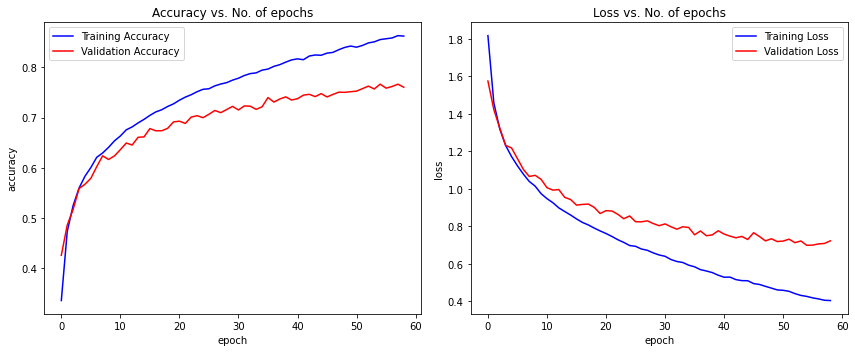

In [50]:
plot_metrics(history_res)

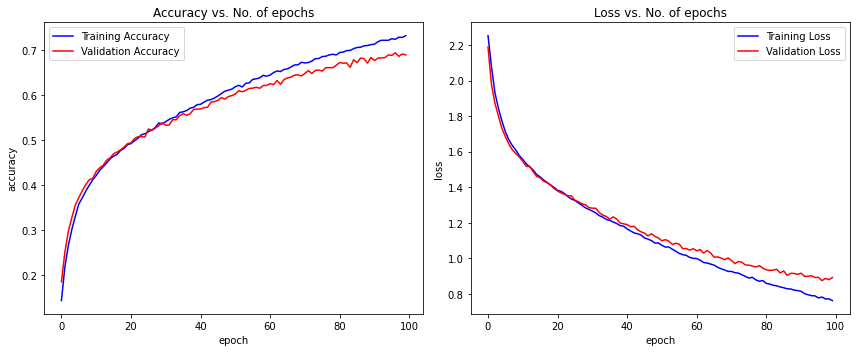

In [51]:
plot_metrics(history_mob)

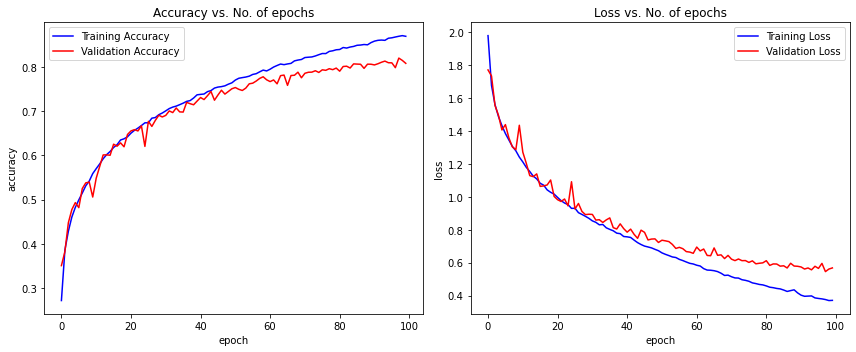

In [52]:
plot_metrics(history_alex)

## 4. Comparison

In [53]:
accuracies

{'Baseline': 0.7041703462600708,
 'ResNet': 0.7606419920921326,
 'MobileNet': 0.689172625541687,
 'AlexNet': 0.8075658082962036}

In [54]:
efficiencies

{'Baseline': 0.6770868714039142,
 'ResNet': 0.21187799222622078,
 'MobileNet': 1.1486210425694785,
 'ALexNet': 0.5809825958965494}

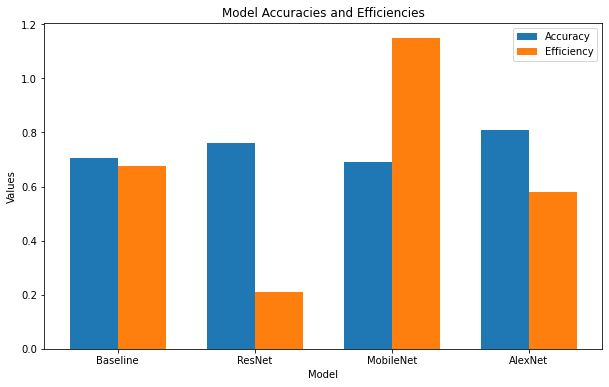

In [60]:
models = list(accuracies.keys())
accuracy_values = list(accuracies.values())
efficiency_values = list(efficiencies.values())

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(10, 6))
plt.bar(index, accuracy_values, bar_width, label='Accuracy')
plt.bar(index + bar_width, efficiency_values, bar_width, label='Efficiency')

plt.xlabel('Model')
plt.ylabel('Values')
plt.title('Model Accuracies and Efficiencies')
plt.xticks(index + bar_width / 2, models)  
plt.legend()
plt.show()

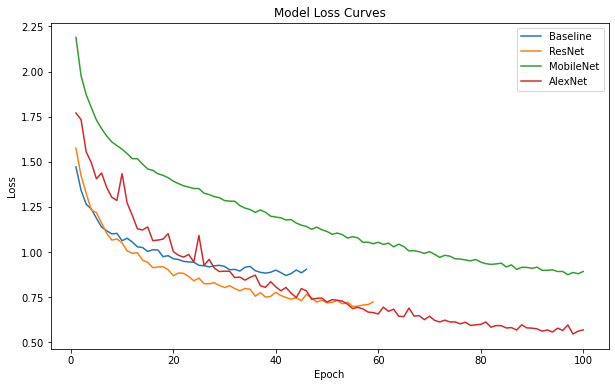

In [56]:

plt.figure(figsize=(10, 6))
for model_name, loss_curve in losses.items():
    epochs = range(1, len(loss_curve) + 1)  
    plt.plot(epochs, loss_curve, label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Curves')
plt.legend()
plt.show()


In [59]:
checkpoint = {
    'models': {
        'baseline': {
            'model_state': model_baseline.state_dict(),
            'optimizer_state': opt_baseline.state_dict(),
            'history': history_baseline,
            'val_acc': val_acc_baseline,
            'flop': flop_baseline,
            'efficiency': efficiency_baseline
        },
        'resnet': {
            'model_state': model_res.state_dict(),
            'optimizer_state': opt_res.state_dict(),
            'history': history_res,
            'val_acc': val_acc_res,
            'flop': flop_res,
            'efficiency': efficiency_res
        },
        'mobilenet': {
            'model_state': model_mob.state_dict(),
            'optimizer_state': opt_mob.state_dict(),
            'history': history_mob,
            'val_acc': val_acc_mob,
            'flop': flop_mob,
            'efficiency': efficiency_mob
        },
        'alexnet': {
            'model_state': model_alex.state_dict(),
            'optimizer_state': opt_alex.state_dict(),
            'history': history_alex,
            'val_acc': val_acc_alex,
            'flop': flop_alex,
            'efficiency': efficiency_alex
        }
    },
    'accuracies': accuracies,
    'efficiencies': efficiencies,
    'losses': losses
}

torch.save(checkpoint, '/home/ubuntu/model1_checkpoint.pth')


In [ ]:
checkpoint = torch.load('/home/ubuntu/model1_checkpoint.pth')

model_baseline.load_state_dict(checkpoint['models']['baseline']['model_state'])
opt_baseline.load_state_dict(checkpoint['models']['baseline']['optimizer_state'])
history_baseline = checkpoint['models']['baseline']['history']
val_acc_baseline = checkpoint['models']['baseline']['val_acc']
flop_baseline = checkpoint['models']['baseline']['flop']
efficiency_baseline = checkpoint['models']['baseline']['efficiency']

model_res.load_state_dict(checkpoint['models']['resnet']['model_state'])
opt_res.load_state_dict(checkpoint['models']['resnet']['optimizer_state'])
history_res = checkpoint['models']['resnet']['history']
val_acc_res = checkpoint['models']['resnet']['val_acc']
flop_res = checkpoint['models']['resnet']['flop']
efficiency_res = checkpoint['models']['resnet']['efficiency']

model_mob.load_state_dict(checkpoint['models']['mobilenet']['model_state'])
opt_mob.load_state_dict(checkpoint['models']['mobilenet']['optimizer_state'])
history_mob = checkpoint['models']['mobilenet']['history']
val_acc_mob = checkpoint['models']['mobilenet']['val_acc']
flop_mob = checkpoint['models']['mobilenet']['flop']
efficiency_mob = checkpoint['models']['mobilenet']['efficiency']

model_alex.load_state_dict(checkpoint['models']['alexnet']['model_state'])
opt_alex.load_state_dict(checkpoint['models']['alexnet']['optimizer_state'])
history_alex = checkpoint['models']['alexnet']['history']
val_acc_alex = checkpoint['models']['alexnet']['val_acc']
flop_alex = checkpoint['models']['alexnet']['flop']
efficiency_alex = checkpoint['models']['alexnet']['efficiency']

accuracies = checkpoint['accuracies']
efficiencies = checkpoint['efficiencies']
losses = checkpoint['losses']

## 5. Optimization of AlexNet

In [17]:
class AlexNetModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.alexnet(pretrained=False)
        
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)

    def forward(self, X):
        return self.model(X)

In [29]:
def fit2(model, train_loader, val_loader, optimizer, patience=5, max_epochs=100):
    history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0  
    epoch = 0  
    scaler = GradScaler()

    while epoch < max_epochs:
        epoch += 1
        model.train()
        train_losses = []
        train_accs = []  

        for batch in tqdm(train_loader):
            with autocast():
                loss, acc = model.training_step(batch)
            train_losses.append(loss.detach())
            train_accs.append(acc)
            
            scaler.scale(loss).backward() 
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_train_loss = torch.stack(train_losses).mean().item()
        avg_train_acc = torch.stack(train_accs).mean().item()
        
        result = evaluate(model, val_loader)
        val_loss = result['val_loss']
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss  
            no_improve_epochs = 0  
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} due to {patience} consecutive epochs with no improvement in val_loss.")
                break 

        result['train_loss'] = avg_train_loss
        result['train_acc'] = avg_train_acc
        model.epoch_end(epoch, result)
        history.append(result)
        if epoch == 10 and avg_train_acc < 0.3:
            print("Stopping due to low validation accuracy.")
            break

    final_val_acc = history[-1]['val_acc'] if history else 0
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    return history, final_val_acc

In [31]:
model_alex1 = AlexNetModel(num_classes)
model_alex1 = model_alex1.to(device)

In [33]:
opt_alex1 = optim.Adam(model_alex1.parameters(), lr=1e-5, weight_decay=1e-4)
history_alex1, val_acc_alex1 = fit2(model_alex1, train_loader, valid_loader, opt_alex1)

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.26it/s]


Epoch [1], train_loss: 2.0034, train_acc: 0.2593, val_loss: 1.8256, val_acc: 0.3371


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.54it/s]


Epoch [2], train_loss: 1.6869, train_acc: 0.3862, val_loss: 1.6054, val_acc: 0.4206


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:53<00:00,  6.20it/s]


Epoch [3], train_loss: 1.5595, train_acc: 0.4332, val_loss: 1.5137, val_acc: 0.4521


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.79it/s]


Epoch [4], train_loss: 1.4805, train_acc: 0.4652, val_loss: 1.4363, val_acc: 0.4864


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [5], train_loss: 1.4190, train_acc: 0.4857, val_loss: 1.4139, val_acc: 0.4953


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.69it/s]


Epoch [6], train_loss: 1.3773, train_acc: 0.5049, val_loss: 1.3548, val_acc: 0.5191


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.60it/s]


Epoch [7], train_loss: 1.3370, train_acc: 0.5209, val_loss: 1.3085, val_acc: 0.5270


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.65it/s]


Epoch [8], train_loss: 1.2965, train_acc: 0.5348, val_loss: 1.2942, val_acc: 0.5436


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [9], train_loss: 1.2630, train_acc: 0.5476, val_loss: 1.2424, val_acc: 0.5546


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.71it/s]


Epoch [10], train_loss: 1.2314, train_acc: 0.5631, val_loss: 1.2344, val_acc: 0.5590


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.72it/s]


Epoch [11], train_loss: 1.2032, train_acc: 0.5723, val_loss: 1.1906, val_acc: 0.5774


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.48it/s]


Epoch [12], train_loss: 1.1780, train_acc: 0.5830, val_loss: 1.1508, val_acc: 0.5870


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [13], train_loss: 1.1462, train_acc: 0.5932, val_loss: 1.1327, val_acc: 0.5977


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.54it/s]


Epoch [14], train_loss: 1.1230, train_acc: 0.6023, val_loss: 1.1106, val_acc: 0.6012


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [15], train_loss: 1.0972, train_acc: 0.6108, val_loss: 1.0919, val_acc: 0.6090


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [16], train_loss: 1.0743, train_acc: 0.6178, val_loss: 1.0662, val_acc: 0.6216


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.43it/s]


Epoch [17], train_loss: 1.0507, train_acc: 0.6301, val_loss: 1.0594, val_acc: 0.6280


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:48<00:00,  6.89it/s]


Epoch [18], train_loss: 1.0373, train_acc: 0.6339, val_loss: 1.0630, val_acc: 0.6245


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.21it/s]


Epoch [19], train_loss: 1.0212, train_acc: 0.6417, val_loss: 1.0374, val_acc: 0.6315


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.28it/s]


Epoch [20], train_loss: 0.9997, train_acc: 0.6486, val_loss: 0.9815, val_acc: 0.6520


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.55it/s]


Epoch [21], train_loss: 0.9864, train_acc: 0.6529, val_loss: 0.9994, val_acc: 0.6484


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.41it/s]


Epoch [22], train_loss: 0.9712, train_acc: 0.6580, val_loss: 0.9771, val_acc: 0.6594


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.43it/s]


Epoch [23], train_loss: 0.9505, train_acc: 0.6634, val_loss: 0.9399, val_acc: 0.6680


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.30it/s]


Epoch [24], train_loss: 0.9369, train_acc: 0.6712, val_loss: 0.9490, val_acc: 0.6620


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.46it/s]


Epoch [25], train_loss: 0.9240, train_acc: 0.6757, val_loss: 0.9150, val_acc: 0.6815


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.45it/s]


Epoch [26], train_loss: 0.9086, train_acc: 0.6793, val_loss: 0.9017, val_acc: 0.6847


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.28it/s]


Epoch [27], train_loss: 0.8947, train_acc: 0.6832, val_loss: 0.9176, val_acc: 0.6829


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.40it/s]


Epoch [28], train_loss: 0.8879, train_acc: 0.6880, val_loss: 0.9192, val_acc: 0.6743


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.45it/s]


Epoch [29], train_loss: 0.8760, train_acc: 0.6937, val_loss: 0.9282, val_acc: 0.6693


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:47<00:00,  6.98it/s]


Epoch [30], train_loss: 0.8578, train_acc: 0.6989, val_loss: 0.8733, val_acc: 0.6950


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.48it/s]


Epoch [31], train_loss: 0.8432, train_acc: 0.7045, val_loss: 0.8571, val_acc: 0.6981


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.14it/s]


Epoch [32], train_loss: 0.8326, train_acc: 0.7108, val_loss: 0.8555, val_acc: 0.7036


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.69it/s]


Epoch [33], train_loss: 0.8286, train_acc: 0.7110, val_loss: 0.8496, val_acc: 0.6995


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:51<00:00,  6.42it/s]


Epoch [34], train_loss: 0.8174, train_acc: 0.7141, val_loss: 0.8642, val_acc: 0.7048


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:50<00:00,  6.55it/s]


Epoch [35], train_loss: 0.8083, train_acc: 0.7183, val_loss: 0.8208, val_acc: 0.7190


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:51<00:00,  6.52it/s]


Epoch [36], train_loss: 0.7976, train_acc: 0.7180, val_loss: 0.8066, val_acc: 0.7200


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.68it/s]


Epoch [37], train_loss: 0.7801, train_acc: 0.7255, val_loss: 0.8076, val_acc: 0.7199


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:51<00:00,  6.45it/s]


Epoch [38], train_loss: 0.7748, train_acc: 0.7294, val_loss: 0.8091, val_acc: 0.7153


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.70it/s]


Epoch [39], train_loss: 0.7643, train_acc: 0.7315, val_loss: 0.7907, val_acc: 0.7216


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.76it/s]


Epoch [40], train_loss: 0.7559, train_acc: 0.7349, val_loss: 0.7791, val_acc: 0.7298


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [41], train_loss: 0.7382, train_acc: 0.7410, val_loss: 0.7726, val_acc: 0.7298


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.73it/s]


Epoch [42], train_loss: 0.7336, train_acc: 0.7452, val_loss: 0.7603, val_acc: 0.7372


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.90it/s]


Epoch [43], train_loss: 0.7145, train_acc: 0.7489, val_loss: 0.7610, val_acc: 0.7401


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.74it/s]


Epoch [44], train_loss: 0.7093, train_acc: 0.7528, val_loss: 0.7616, val_acc: 0.7357


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [45], train_loss: 0.7003, train_acc: 0.7552, val_loss: 0.7859, val_acc: 0.7218


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.76it/s]


Epoch [46], train_loss: 0.6933, train_acc: 0.7581, val_loss: 0.7429, val_acc: 0.7398


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.56it/s]


Epoch [47], train_loss: 0.6824, train_acc: 0.7608, val_loss: 0.7264, val_acc: 0.7423


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [48], train_loss: 0.6692, train_acc: 0.7659, val_loss: 0.7273, val_acc: 0.7459


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.70it/s]


Epoch [49], train_loss: 0.6640, train_acc: 0.7696, val_loss: 0.7499, val_acc: 0.7354


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.71it/s]


Epoch [50], train_loss: 0.6571, train_acc: 0.7695, val_loss: 0.7231, val_acc: 0.7509


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.82it/s]


Epoch [51], train_loss: 0.6509, train_acc: 0.7711, val_loss: 0.7086, val_acc: 0.7574


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [52], train_loss: 0.6384, train_acc: 0.7759, val_loss: 0.7283, val_acc: 0.7472


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.74it/s]


Epoch [53], train_loss: 0.6334, train_acc: 0.7777, val_loss: 0.6884, val_acc: 0.7594


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.71it/s]


Epoch [54], train_loss: 0.6273, train_acc: 0.7810, val_loss: 0.6927, val_acc: 0.7552


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.79it/s]


Epoch [55], train_loss: 0.6137, train_acc: 0.7851, val_loss: 0.6804, val_acc: 0.7684


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.95it/s]


Epoch [56], train_loss: 0.6037, train_acc: 0.7897, val_loss: 0.6693, val_acc: 0.7714


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [57], train_loss: 0.6009, train_acc: 0.7900, val_loss: 0.6873, val_acc: 0.7586


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.92it/s]


Epoch [58], train_loss: 0.5908, train_acc: 0.7916, val_loss: 0.6595, val_acc: 0.7719


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.98it/s]


Epoch [59], train_loss: 0.5869, train_acc: 0.7932, val_loss: 0.6879, val_acc: 0.7683


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  8.02it/s]


Epoch [60], train_loss: 0.5772, train_acc: 0.7980, val_loss: 0.6613, val_acc: 0.7711


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.91it/s]


Epoch [61], train_loss: 0.5680, train_acc: 0.8027, val_loss: 0.6630, val_acc: 0.7718


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [62], train_loss: 0.5664, train_acc: 0.8017, val_loss: 0.6649, val_acc: 0.7721


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.77it/s]


Epoch [63], train_loss: 0.5563, train_acc: 0.8066, val_loss: 0.6473, val_acc: 0.7772


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.93it/s]


Epoch [64], train_loss: 0.5499, train_acc: 0.8053, val_loss: 0.6648, val_acc: 0.7752


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.93it/s]


Epoch [65], train_loss: 0.5448, train_acc: 0.8099, val_loss: 0.6301, val_acc: 0.7843


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [66], train_loss: 0.5419, train_acc: 0.8100, val_loss: 0.6327, val_acc: 0.7872


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.91it/s]


Epoch [67], train_loss: 0.5342, train_acc: 0.8127, val_loss: 0.6528, val_acc: 0.7777


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [68], train_loss: 0.5242, train_acc: 0.8157, val_loss: 0.6373, val_acc: 0.7841


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [69], train_loss: 0.5188, train_acc: 0.8190, val_loss: 0.6276, val_acc: 0.7841


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [70], train_loss: 0.5084, train_acc: 0.8236, val_loss: 0.6131, val_acc: 0.7888


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.83it/s]


Epoch [71], train_loss: 0.5059, train_acc: 0.8248, val_loss: 0.6193, val_acc: 0.7911


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.62it/s]


Epoch [72], train_loss: 0.4991, train_acc: 0.8262, val_loss: 0.6122, val_acc: 0.7927


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [73], train_loss: 0.4971, train_acc: 0.8279, val_loss: 0.6045, val_acc: 0.7940


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [74], train_loss: 0.4947, train_acc: 0.8276, val_loss: 0.6079, val_acc: 0.7926


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.92it/s]


Epoch [75], train_loss: 0.4812, train_acc: 0.8300, val_loss: 0.6129, val_acc: 0.7862


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [76], train_loss: 0.4808, train_acc: 0.8311, val_loss: 0.6062, val_acc: 0.7948


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [77], train_loss: 0.4664, train_acc: 0.8366, val_loss: 0.6087, val_acc: 0.7924


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.96it/s]


Epoch [78], train_loss: 0.4692, train_acc: 0.8357, val_loss: 0.5908, val_acc: 0.7947


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  8.00it/s]


Epoch [79], train_loss: 0.4574, train_acc: 0.8370, val_loss: 0.5898, val_acc: 0.8033


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  8.02it/s]


Epoch [80], train_loss: 0.4569, train_acc: 0.8385, val_loss: 0.6032, val_acc: 0.7964


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [81], train_loss: 0.4479, train_acc: 0.8429, val_loss: 0.5853, val_acc: 0.8033


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [82], train_loss: 0.4431, train_acc: 0.8431, val_loss: 0.5867, val_acc: 0.7994


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.91it/s]


Epoch [83], train_loss: 0.4356, train_acc: 0.8480, val_loss: 0.5810, val_acc: 0.8005


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.58it/s]


Epoch [84], train_loss: 0.4296, train_acc: 0.8481, val_loss: 0.6235, val_acc: 0.7927


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [85], train_loss: 0.4258, train_acc: 0.8515, val_loss: 0.5762, val_acc: 0.8034


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [86], train_loss: 0.4189, train_acc: 0.8511, val_loss: 0.5767, val_acc: 0.8029


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [87], train_loss: 0.4126, train_acc: 0.8550, val_loss: 0.5809, val_acc: 0.8013


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.77it/s]


Epoch [88], train_loss: 0.4111, train_acc: 0.8552, val_loss: 0.5758, val_acc: 0.8031


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.80it/s]


Epoch [89], train_loss: 0.4047, train_acc: 0.8555, val_loss: 0.5775, val_acc: 0.8048


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [90], train_loss: 0.3993, train_acc: 0.8596, val_loss: 0.5696, val_acc: 0.8068


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.91it/s]


Epoch [91], train_loss: 0.3934, train_acc: 0.8626, val_loss: 0.5623, val_acc: 0.8061


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [92], train_loss: 0.3870, train_acc: 0.8640, val_loss: 0.5688, val_acc: 0.8088


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.96it/s]


Epoch [93], train_loss: 0.3842, train_acc: 0.8663, val_loss: 0.5755, val_acc: 0.8090


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.95it/s]


Epoch [94], train_loss: 0.3822, train_acc: 0.8667, val_loss: 0.5583, val_acc: 0.8120


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.94it/s]


Epoch [95], train_loss: 0.3723, train_acc: 0.8697, val_loss: 0.5725, val_acc: 0.8120


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.92it/s]


Epoch [96], train_loss: 0.3704, train_acc: 0.8693, val_loss: 0.5690, val_acc: 0.8076


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [97], train_loss: 0.3654, train_acc: 0.8716, val_loss: 0.5697, val_acc: 0.8103


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [98], train_loss: 0.3628, train_acc: 0.8721, val_loss: 0.5568, val_acc: 0.8099


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.76it/s]


Epoch [99], train_loss: 0.3591, train_acc: 0.8716, val_loss: 0.5574, val_acc: 0.8069


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.80it/s]


Epoch [100], train_loss: 0.3528, train_acc: 0.8757, val_loss: 0.5622, val_acc: 0.8099
Final Validation Accuracy: 0.8099


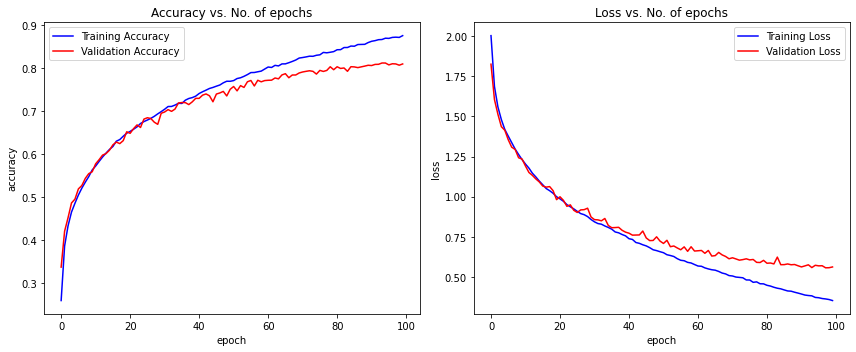

In [34]:
plot_metrics(history_alex1)

In [ ]:
accuracies['Model1'] = val_acc_alex1
losses['Model1'] = [x.get('val_loss') for x in history_alex1]

In [35]:
model_alex2 = AlexNetModel(num_classes)
model_alex2 = model_alex2.to(device)

In [37]:
opt_alex2 = optim.SGD(model_alex2.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
history_alex2, val_acc_alex2 = fit2(model_alex2, train_loader, valid_loader, opt_alex2)

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.25it/s]


Epoch [1], train_loss: 1.9972, train_acc: 0.2569, val_loss: 1.7222, val_acc: 0.3605


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:47<00:00,  7.08it/s]


Epoch [2], train_loss: 1.5384, train_acc: 0.4364, val_loss: 1.7176, val_acc: 0.3862


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.50it/s]


Epoch [3], train_loss: 1.3440, train_acc: 0.5126, val_loss: 1.3766, val_acc: 0.5218


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.76it/s]


Epoch [4], train_loss: 1.1249, train_acc: 0.6040, val_loss: 1.0227, val_acc: 0.6354


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [5], train_loss: 0.9748, train_acc: 0.6551, val_loss: 1.2588, val_acc: 0.5618


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.26it/s]


Epoch [6], train_loss: 0.9226, train_acc: 0.6745, val_loss: 1.0962, val_acc: 0.6267


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:48<00:00,  6.85it/s]


Epoch [7], train_loss: 0.8583, train_acc: 0.6996, val_loss: 0.8484, val_acc: 0.7097


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.19it/s]


Epoch [8], train_loss: 0.7603, train_acc: 0.7354, val_loss: 0.7927, val_acc: 0.7321


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [9], train_loss: 0.7054, train_acc: 0.7539, val_loss: 0.7260, val_acc: 0.7536


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.91it/s]


Epoch [10], train_loss: 0.6522, train_acc: 0.7750, val_loss: 0.6857, val_acc: 0.7698


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.93it/s]


Epoch [11], train_loss: 0.6207, train_acc: 0.7832, val_loss: 0.7085, val_acc: 0.7531


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.64it/s]


Epoch [12], train_loss: 0.5963, train_acc: 0.7916, val_loss: 0.8438, val_acc: 0.7228


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.63it/s]


Epoch [13], train_loss: 0.5825, train_acc: 0.7971, val_loss: 0.6098, val_acc: 0.7870


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.18it/s]


Epoch [14], train_loss: 0.5267, train_acc: 0.8188, val_loss: 0.6478, val_acc: 0.7775


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:51<00:00,  6.46it/s]


Epoch [15], train_loss: 0.5103, train_acc: 0.8238, val_loss: 0.6641, val_acc: 0.7677


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:50<00:00,  6.64it/s]


Epoch [16], train_loss: 0.5009, train_acc: 0.8256, val_loss: 0.5732, val_acc: 0.8046


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.78it/s]


Epoch [17], train_loss: 0.4618, train_acc: 0.8392, val_loss: 0.5336, val_acc: 0.8190


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:48<00:00,  6.80it/s]


Epoch [18], train_loss: 0.4402, train_acc: 0.8486, val_loss: 0.5722, val_acc: 0.8029


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:51<00:00,  6.49it/s]


Epoch [19], train_loss: 0.4440, train_acc: 0.8473, val_loss: 0.6840, val_acc: 0.7845


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:51<00:00,  6.47it/s]


Epoch [20], train_loss: 0.4166, train_acc: 0.8561, val_loss: 0.5646, val_acc: 0.8046


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:47<00:00,  6.96it/s]


Epoch [21], train_loss: 0.3941, train_acc: 0.8630, val_loss: 0.5228, val_acc: 0.8242


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.69it/s]


Epoch [22], train_loss: 0.3780, train_acc: 0.8687, val_loss: 0.5156, val_acc: 0.8279


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.70it/s]


Epoch [23], train_loss: 0.3568, train_acc: 0.8751, val_loss: 0.4802, val_acc: 0.8386


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:47<00:00,  7.03it/s]


Epoch [24], train_loss: 0.3735, train_acc: 0.8715, val_loss: 0.5246, val_acc: 0.8231


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.71it/s]


Epoch [25], train_loss: 0.3597, train_acc: 0.8749, val_loss: 0.5073, val_acc: 0.8357


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.69it/s]


Epoch [26], train_loss: 0.3325, train_acc: 0.8837, val_loss: 0.5070, val_acc: 0.8346


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.35it/s]


Epoch [27], train_loss: 0.3293, train_acc: 0.8863, val_loss: 0.6223, val_acc: 0.8010


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.47it/s]


Early stopping at epoch 28 due to 5 consecutive epochs with no improvement in val_loss.
Final Validation Accuracy: 0.8010


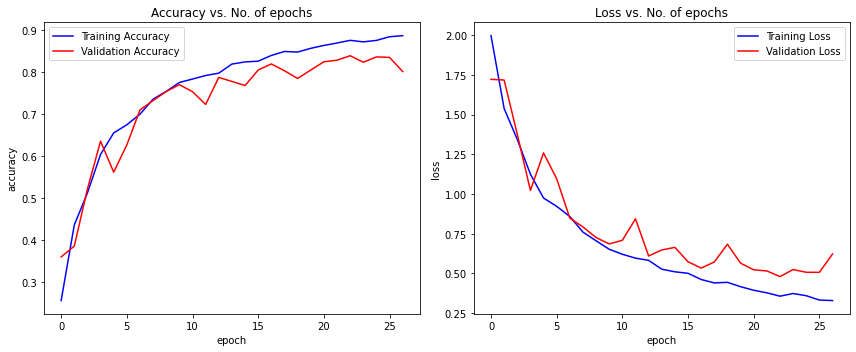

In [38]:
plot_metrics(history_alex2)

In [40]:

def fit3(model, train_loader, val_loader, optimizer, patience=5, max_epochs=100):
    history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0  
    epoch = 0  
    scaler = GradScaler()
    
    T_max = 50  
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)

    while epoch < max_epochs:
        epoch += 1
        model.train()
        train_losses = []
        train_accs = []  

        for batch in tqdm(train_loader):
            with autocast():
                loss, acc = model.training_step(batch)
            train_losses.append(loss.detach())
            train_accs.append(acc)
            
            scaler.scale(loss).backward() 
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_train_loss = torch.stack(train_losses).mean().item()
        avg_train_acc = torch.stack(train_accs).mean().item()
        
        result = evaluate(model, val_loader)
        val_loss = result['val_loss']
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss  
            no_improve_epochs = 0  
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} due to {patience} consecutive epochs with no improvement in val_loss.")
                break 

        result['train_loss'] = avg_train_loss
        result['train_acc'] = avg_train_acc
        model.epoch_end(epoch, result)
        history.append(result)
        
        scheduler.step()

        if epoch == 10 and avg_train_acc < 0.3:
            print("Stopping due to low training accuracy.")
            break

    final_val_acc = history[-1]['val_acc'] if history else 0
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    return history, final_val_acc


In [41]:
model_alex3 = AlexNetModel(num_classes)
model_alex3 = model_alex3.to(device)

In [42]:
opt_alex3 = optim.SGD(model_alex3.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-3)
history_alex3, val_acc_alex3 = fit3(model_alex3, train_loader, valid_loader, opt_alex3)

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.87it/s]


Epoch [1], train_loss: 2.3014, train_acc: 0.1080, val_loss: 2.2988, val_acc: 0.1235


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.50it/s]


Epoch [2], train_loss: 2.2709, train_acc: 0.1316, val_loss: 2.1926, val_acc: 0.2060


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.28it/s]


Epoch [3], train_loss: 2.0811, train_acc: 0.2455, val_loss: 2.0077, val_acc: 0.2501


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.30it/s]


Epoch [4], train_loss: 1.9419, train_acc: 0.2824, val_loss: 1.9429, val_acc: 0.2808


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.73it/s]


Epoch [5], train_loss: 1.8092, train_acc: 0.3313, val_loss: 1.9107, val_acc: 0.3334


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.41it/s]


Epoch [6], train_loss: 1.6929, train_acc: 0.3759, val_loss: 1.7046, val_acc: 0.3837


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.43it/s]


Epoch [7], train_loss: 1.6172, train_acc: 0.4070, val_loss: 1.5779, val_acc: 0.4219


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.73it/s]


Epoch [8], train_loss: 1.5367, train_acc: 0.4364, val_loss: 1.5743, val_acc: 0.4381


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [9], train_loss: 1.4599, train_acc: 0.4694, val_loss: 1.4311, val_acc: 0.4794


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.71it/s]


Epoch [10], train_loss: 1.4097, train_acc: 0.4873, val_loss: 1.4483, val_acc: 0.4793


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.74it/s]


Epoch [11], train_loss: 1.3530, train_acc: 0.5087, val_loss: 1.2996, val_acc: 0.5294


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [12], train_loss: 1.3158, train_acc: 0.5266, val_loss: 1.7110, val_acc: 0.4086


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.67it/s]


Epoch [13], train_loss: 1.2894, train_acc: 0.5381, val_loss: 1.2898, val_acc: 0.5459


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.62it/s]


Epoch [14], train_loss: 1.2307, train_acc: 0.5610, val_loss: 1.2310, val_acc: 0.5636


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [15], train_loss: 1.1977, train_acc: 0.5738, val_loss: 1.2225, val_acc: 0.5692


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.61it/s]


Epoch [16], train_loss: 1.1693, train_acc: 0.5875, val_loss: 1.1251, val_acc: 0.6010


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [17], train_loss: 1.1302, train_acc: 0.5996, val_loss: 1.1097, val_acc: 0.6124


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.76it/s]


Epoch [18], train_loss: 1.0992, train_acc: 0.6070, val_loss: 1.2788, val_acc: 0.5661


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.73it/s]


Epoch [19], train_loss: 1.0778, train_acc: 0.6189, val_loss: 1.0359, val_acc: 0.6319


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [20], train_loss: 1.0431, train_acc: 0.6284, val_loss: 1.0389, val_acc: 0.6359


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [21], train_loss: 1.0110, train_acc: 0.6421, val_loss: 1.0236, val_acc: 0.6387


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.80it/s]


Epoch [22], train_loss: 0.9931, train_acc: 0.6503, val_loss: 0.9612, val_acc: 0.6639


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [23], train_loss: 0.9668, train_acc: 0.6602, val_loss: 0.9704, val_acc: 0.6588


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.77it/s]


Epoch [24], train_loss: 0.9580, train_acc: 0.6628, val_loss: 0.9215, val_acc: 0.6726


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [25], train_loss: 0.9209, train_acc: 0.6754, val_loss: 0.9154, val_acc: 0.6764


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [26], train_loss: 0.9044, train_acc: 0.6822, val_loss: 0.8913, val_acc: 0.6858


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.77it/s]


Epoch [27], train_loss: 0.8882, train_acc: 0.6883, val_loss: 0.9281, val_acc: 0.6756


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.84it/s]


Epoch [28], train_loss: 0.8746, train_acc: 0.6925, val_loss: 0.8809, val_acc: 0.6898


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [29], train_loss: 0.8606, train_acc: 0.6979, val_loss: 0.8584, val_acc: 0.7040


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.78it/s]


Epoch [30], train_loss: 0.8461, train_acc: 0.7038, val_loss: 0.8735, val_acc: 0.6948


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.74it/s]


Epoch [31], train_loss: 0.8269, train_acc: 0.7085, val_loss: 0.8458, val_acc: 0.6983


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.76it/s]


Epoch [32], train_loss: 0.8209, train_acc: 0.7147, val_loss: 0.8428, val_acc: 0.7090


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.79it/s]


Epoch [33], train_loss: 0.8099, train_acc: 0.7166, val_loss: 0.8164, val_acc: 0.7177


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.82it/s]


Epoch [34], train_loss: 0.8068, train_acc: 0.7158, val_loss: 0.8063, val_acc: 0.7204


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.89it/s]


Epoch [35], train_loss: 0.7919, train_acc: 0.7228, val_loss: 0.8010, val_acc: 0.7228


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.98it/s]


Epoch [36], train_loss: 0.7821, train_acc: 0.7279, val_loss: 0.7905, val_acc: 0.7228


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.92it/s]


Epoch [37], train_loss: 0.7825, train_acc: 0.7247, val_loss: 0.7940, val_acc: 0.7267


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:41<00:00,  7.93it/s]


Epoch [38], train_loss: 0.7724, train_acc: 0.7275, val_loss: 0.7712, val_acc: 0.7348


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.88it/s]


Epoch [39], train_loss: 0.7596, train_acc: 0.7337, val_loss: 0.7810, val_acc: 0.7300


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.65it/s]


Epoch [40], train_loss: 0.7599, train_acc: 0.7336, val_loss: 0.7644, val_acc: 0.7349


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.69it/s]


Epoch [41], train_loss: 0.7521, train_acc: 0.7369, val_loss: 0.7797, val_acc: 0.7291


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.75it/s]


Epoch [42], train_loss: 0.7415, train_acc: 0.7395, val_loss: 0.7698, val_acc: 0.7327


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.86it/s]


Epoch [43], train_loss: 0.7439, train_acc: 0.7419, val_loss: 0.7728, val_acc: 0.7381


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:43<00:00,  7.68it/s]


Epoch [44], train_loss: 0.7412, train_acc: 0.7409, val_loss: 0.7625, val_acc: 0.7371


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.55it/s]


Epoch [45], train_loss: 0.7409, train_acc: 0.7398, val_loss: 0.7572, val_acc: 0.7332


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:47<00:00,  6.98it/s]


Epoch [46], train_loss: 0.7387, train_acc: 0.7404, val_loss: 0.7533, val_acc: 0.7393


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.19it/s]


Epoch [47], train_loss: 0.7354, train_acc: 0.7411, val_loss: 0.7572, val_acc: 0.7394


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.23it/s]


Epoch [48], train_loss: 0.7297, train_acc: 0.7449, val_loss: 0.7477, val_acc: 0.7380


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:45<00:00,  7.33it/s]


Epoch [49], train_loss: 0.7291, train_acc: 0.7438, val_loss: 0.7565, val_acc: 0.7402


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:46<00:00,  7.15it/s]


Epoch [50], train_loss: 0.7333, train_acc: 0.7444, val_loss: 0.7489, val_acc: 0.7366


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:44<00:00,  7.52it/s]


Epoch [51], train_loss: 0.7284, train_acc: 0.7438, val_loss: 0.7531, val_acc: 0.7420


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:42<00:00,  7.85it/s]


Epoch [52], train_loss: 0.7345, train_acc: 0.7434, val_loss: 0.7533, val_acc: 0.7373


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:52<00:00,  6.30it/s]


Early stopping at epoch 53 due to 5 consecutive epochs with no improvement in val_loss.
Final Validation Accuracy: 0.7373


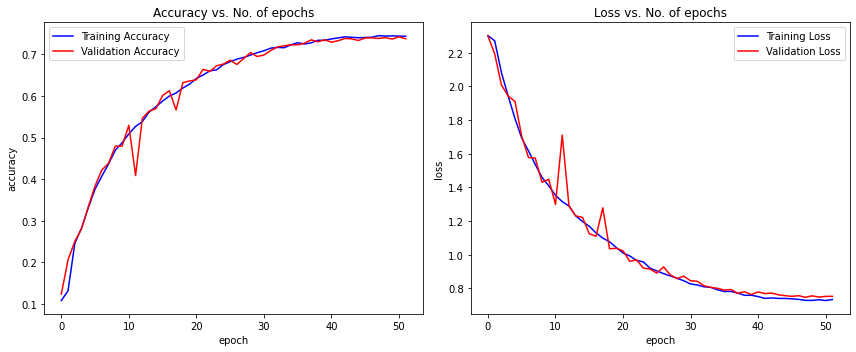

In [43]:
plot_metrics(history_alex3)

In [44]:
# New transformer Transformations. 
train_transform2 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

full_trainset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform2)

trainset2, validset2 = random_split(full_trainset2, [train_size, valid_size])

train_loader2 = DataLoader(dataset=trainset2, batch_size=128, shuffle=True, num_workers=2)
valid_loader2 = DataLoader(dataset=validset2, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [45]:
# tranfer dataset into cuda
device = get_default_device()
train_loader2 = DeviceDataLoader(train_loader2, device)
valid_loader2 = DeviceDataLoader(valid_loader2, device)


In [46]:
model_alex4 = AlexNetModel(num_classes)
model_alex4 = model_alex4.to(device)

In [48]:
opt_alex4 = optim.SGD(model_alex4.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-3)
history_alex4, val_acc_alex4 = fit3(model_alex4, train_loader2, valid_loader2, opt_alex4, patience=10)

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.95it/s]


Epoch [1], train_loss: 2.3020, train_acc: 0.1139, val_loss: 2.3008, val_acc: 0.1071


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:56<00:00,  2.87it/s]


Epoch [2], train_loss: 2.2987, train_acc: 0.1177, val_loss: 2.2920, val_acc: 0.1279


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.94it/s]


Epoch [3], train_loss: 2.2162, train_acc: 0.1712, val_loss: 2.0721, val_acc: 0.2452


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.88it/s]


Epoch [4], train_loss: 1.9831, train_acc: 0.2779, val_loss: 1.9107, val_acc: 0.3166


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.94it/s]


Epoch [5], train_loss: 1.8400, train_acc: 0.3254, val_loss: 1.7553, val_acc: 0.3569


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:57<00:00,  2.83it/s]


Epoch [6], train_loss: 1.7381, train_acc: 0.3599, val_loss: 1.7460, val_acc: 0.3697


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.87it/s]


Epoch [7], train_loss: 1.6715, train_acc: 0.3904, val_loss: 1.6013, val_acc: 0.4183


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:56<00:00,  2.86it/s]


Epoch [8], train_loss: 1.6176, train_acc: 0.4130, val_loss: 1.6138, val_acc: 0.4230


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [9], train_loss: 1.5642, train_acc: 0.4308, val_loss: 1.6738, val_acc: 0.4037


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [10], train_loss: 1.5190, train_acc: 0.4514, val_loss: 1.5800, val_acc: 0.4467


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [02:00<00:00,  2.76it/s]


Epoch [11], train_loss: 1.4689, train_acc: 0.4729, val_loss: 1.4410, val_acc: 0.4806


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [02:14<00:00,  2.47it/s]


Epoch [12], train_loss: 1.4255, train_acc: 0.4892, val_loss: 1.4304, val_acc: 0.4955


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [02:00<00:00,  2.76it/s]


Epoch [13], train_loss: 1.3859, train_acc: 0.5037, val_loss: 1.3747, val_acc: 0.5151


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [02:02<00:00,  2.71it/s]


Epoch [14], train_loss: 1.3476, train_acc: 0.5211, val_loss: 1.3172, val_acc: 0.5407


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:57<00:00,  2.83it/s]


Epoch [15], train_loss: 1.3145, train_acc: 0.5297, val_loss: 1.3124, val_acc: 0.5389


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:57<00:00,  2.84it/s]


Epoch [16], train_loss: 1.2778, train_acc: 0.5469, val_loss: 1.2818, val_acc: 0.5490


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [17], train_loss: 1.2315, train_acc: 0.5605, val_loss: 1.2810, val_acc: 0.5595


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [18], train_loss: 1.2139, train_acc: 0.5709, val_loss: 1.2512, val_acc: 0.5657


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [19], train_loss: 1.1782, train_acc: 0.5839, val_loss: 1.1973, val_acc: 0.5909


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [20], train_loss: 1.1514, train_acc: 0.5947, val_loss: 1.1285, val_acc: 0.6071


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [21], train_loss: 1.1225, train_acc: 0.6034, val_loss: 1.1426, val_acc: 0.6053


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.09it/s]


Epoch [22], train_loss: 1.0994, train_acc: 0.6150, val_loss: 1.0821, val_acc: 0.6206


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.03it/s]


Epoch [23], train_loss: 1.0732, train_acc: 0.6247, val_loss: 1.0753, val_acc: 0.6282


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.89it/s]


Epoch [24], train_loss: 1.0548, train_acc: 0.6287, val_loss: 1.1234, val_acc: 0.6261


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [25], train_loss: 1.0269, train_acc: 0.6393, val_loss: 1.0140, val_acc: 0.6513


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [26], train_loss: 1.0054, train_acc: 0.6480, val_loss: 0.9987, val_acc: 0.6542


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [02:00<00:00,  2.77it/s]


Epoch [27], train_loss: 0.9940, train_acc: 0.6522, val_loss: 1.0285, val_acc: 0.6477


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [28], train_loss: 0.9773, train_acc: 0.6575, val_loss: 0.9560, val_acc: 0.6640


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:54<00:00,  2.90it/s]


Epoch [29], train_loss: 0.9559, train_acc: 0.6673, val_loss: 1.0134, val_acc: 0.6602


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [30], train_loss: 0.9367, train_acc: 0.6735, val_loss: 0.9213, val_acc: 0.6888


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [31], train_loss: 0.9292, train_acc: 0.6771, val_loss: 1.0407, val_acc: 0.6531


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.94it/s]


Epoch [32], train_loss: 0.9139, train_acc: 0.6831, val_loss: 0.9498, val_acc: 0.6738


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.88it/s]


Epoch [33], train_loss: 0.9007, train_acc: 0.6856, val_loss: 0.8995, val_acc: 0.6920


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:54<00:00,  2.90it/s]


Epoch [34], train_loss: 0.8936, train_acc: 0.6879, val_loss: 0.9072, val_acc: 0.6852


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [35], train_loss: 0.8794, train_acc: 0.6962, val_loss: 0.8584, val_acc: 0.7065


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.09it/s]


Epoch [36], train_loss: 0.8658, train_acc: 0.6993, val_loss: 0.8988, val_acc: 0.6957


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.99it/s]


Epoch [37], train_loss: 0.8664, train_acc: 0.7008, val_loss: 0.8585, val_acc: 0.7084


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [38], train_loss: 0.8555, train_acc: 0.7008, val_loss: 0.8603, val_acc: 0.7046


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.01it/s]


Epoch [39], train_loss: 0.8447, train_acc: 0.7078, val_loss: 0.8509, val_acc: 0.7084


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:57<00:00,  2.83it/s]


Epoch [40], train_loss: 0.8456, train_acc: 0.7079, val_loss: 0.8363, val_acc: 0.7147


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.97it/s]


Epoch [41], train_loss: 0.8391, train_acc: 0.7082, val_loss: 0.8360, val_acc: 0.7115


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [42], train_loss: 0.8317, train_acc: 0.7099, val_loss: 0.8254, val_acc: 0.7166


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.01it/s]


Epoch [43], train_loss: 0.8294, train_acc: 0.7116, val_loss: 0.8373, val_acc: 0.7177


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [44], train_loss: 0.8215, train_acc: 0.7139, val_loss: 0.8430, val_acc: 0.7117


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.99it/s]


Epoch [45], train_loss: 0.8263, train_acc: 0.7144, val_loss: 0.8243, val_acc: 0.7173


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.97it/s]


Epoch [46], train_loss: 0.8158, train_acc: 0.7167, val_loss: 0.8159, val_acc: 0.7169


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.99it/s]


Epoch [47], train_loss: 0.8151, train_acc: 0.7176, val_loss: 0.8325, val_acc: 0.7141


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [48], train_loss: 0.8187, train_acc: 0.7134, val_loss: 0.8158, val_acc: 0.7192


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [49], train_loss: 0.8165, train_acc: 0.7162, val_loss: 0.8221, val_acc: 0.7178


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [50], train_loss: 0.8186, train_acc: 0.7155, val_loss: 0.8115, val_acc: 0.7234


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.00it/s]


Epoch [51], train_loss: 0.8177, train_acc: 0.7151, val_loss: 0.8165, val_acc: 0.7219


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [52], train_loss: 0.8206, train_acc: 0.7158, val_loss: 0.8249, val_acc: 0.7190


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  3.00it/s]


Epoch [53], train_loss: 0.8187, train_acc: 0.7162, val_loss: 0.8237, val_acc: 0.7191


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.00it/s]


Epoch [54], train_loss: 0.8138, train_acc: 0.7177, val_loss: 0.8227, val_acc: 0.7162


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  3.00it/s]


Epoch [55], train_loss: 0.8141, train_acc: 0.7166, val_loss: 0.8229, val_acc: 0.7215


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.97it/s]


Epoch [56], train_loss: 0.8157, train_acc: 0.7171, val_loss: 0.8093, val_acc: 0.7160


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [57], train_loss: 0.8123, train_acc: 0.7172, val_loss: 0.8191, val_acc: 0.7195


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [58], train_loss: 0.8217, train_acc: 0.7151, val_loss: 0.8313, val_acc: 0.7153


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.94it/s]


Epoch [59], train_loss: 0.8161, train_acc: 0.7167, val_loss: 0.8139, val_acc: 0.7197


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.01it/s]


Epoch [60], train_loss: 0.8169, train_acc: 0.7149, val_loss: 0.8255, val_acc: 0.7243


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [61], train_loss: 0.8164, train_acc: 0.7162, val_loss: 0.8132, val_acc: 0.7231


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [62], train_loss: 0.8199, train_acc: 0.7158, val_loss: 0.8284, val_acc: 0.7236


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [63], train_loss: 0.8125, train_acc: 0.7177, val_loss: 0.8155, val_acc: 0.7217


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [64], train_loss: 0.8171, train_acc: 0.7153, val_loss: 0.8167, val_acc: 0.7235


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [65], train_loss: 0.8144, train_acc: 0.7175, val_loss: 0.8055, val_acc: 0.7284


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [66], train_loss: 0.8093, train_acc: 0.7181, val_loss: 0.8145, val_acc: 0.7233


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [67], train_loss: 0.8099, train_acc: 0.7200, val_loss: 0.9530, val_acc: 0.6869


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [68], train_loss: 0.8151, train_acc: 0.7161, val_loss: 0.8132, val_acc: 0.7262


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [69], train_loss: 0.8095, train_acc: 0.7161, val_loss: 0.8287, val_acc: 0.7195


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [70], train_loss: 0.8011, train_acc: 0.7225, val_loss: 0.8108, val_acc: 0.7305


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [71], train_loss: 0.7991, train_acc: 0.7239, val_loss: 0.8113, val_acc: 0.7266


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.09it/s]


Epoch [72], train_loss: 0.8013, train_acc: 0.7230, val_loss: 0.7999, val_acc: 0.7295


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [73], train_loss: 0.7962, train_acc: 0.7239, val_loss: 0.7647, val_acc: 0.7380


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [74], train_loss: 0.7886, train_acc: 0.7269, val_loss: 0.7961, val_acc: 0.7250


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.03it/s]


Epoch [75], train_loss: 0.7867, train_acc: 0.7275, val_loss: 0.8282, val_acc: 0.7193


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [76], train_loss: 0.7730, train_acc: 0.7314, val_loss: 0.7760, val_acc: 0.7325


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.00it/s]


Epoch [77], train_loss: 0.7663, train_acc: 0.7370, val_loss: 0.7843, val_acc: 0.7350


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.00it/s]


Epoch [78], train_loss: 0.7640, train_acc: 0.7375, val_loss: 0.8264, val_acc: 0.7233


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:54<00:00,  2.91it/s]


Epoch [79], train_loss: 0.7567, train_acc: 0.7383, val_loss: 0.7400, val_acc: 0.7482


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [80], train_loss: 0.7470, train_acc: 0.7420, val_loss: 0.8000, val_acc: 0.7309


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [81], train_loss: 0.7505, train_acc: 0.7412, val_loss: 0.7500, val_acc: 0.7469


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.95it/s]


Epoch [82], train_loss: 0.7339, train_acc: 0.7452, val_loss: 0.7909, val_acc: 0.7332


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [83], train_loss: 0.7291, train_acc: 0.7483, val_loss: 0.7754, val_acc: 0.7339


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [84], train_loss: 0.7235, train_acc: 0.7511, val_loss: 0.7240, val_acc: 0.7535


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [85], train_loss: 0.7078, train_acc: 0.7550, val_loss: 0.7473, val_acc: 0.7521


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.92it/s]


Epoch [86], train_loss: 0.7025, train_acc: 0.7565, val_loss: 0.7705, val_acc: 0.7324


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.89it/s]


Epoch [87], train_loss: 0.6939, train_acc: 0.7604, val_loss: 0.7351, val_acc: 0.7528


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.97it/s]


Epoch [88], train_loss: 0.6883, train_acc: 0.7616, val_loss: 0.7127, val_acc: 0.7550


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [89], train_loss: 0.6740, train_acc: 0.7688, val_loss: 0.7274, val_acc: 0.7471


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [90], train_loss: 0.6704, train_acc: 0.7668, val_loss: 0.7032, val_acc: 0.7646


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.95it/s]


Epoch [91], train_loss: 0.6600, train_acc: 0.7706, val_loss: 0.6888, val_acc: 0.7656


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.99it/s]


Epoch [92], train_loss: 0.6563, train_acc: 0.7738, val_loss: 0.6545, val_acc: 0.7786


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [93], train_loss: 0.6392, train_acc: 0.7788, val_loss: 0.6437, val_acc: 0.7809


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [94], train_loss: 0.6318, train_acc: 0.7817, val_loss: 0.6578, val_acc: 0.7764


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [95], train_loss: 0.6290, train_acc: 0.7832, val_loss: 0.6571, val_acc: 0.7811


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.95it/s]


Epoch [96], train_loss: 0.6278, train_acc: 0.7851, val_loss: 0.6838, val_acc: 0.7744


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [97], train_loss: 0.6202, train_acc: 0.7863, val_loss: 0.6724, val_acc: 0.7768


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.97it/s]


Epoch [98], train_loss: 0.6090, train_acc: 0.7884, val_loss: 0.7368, val_acc: 0.7605


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [99], train_loss: 0.6043, train_acc: 0.7924, val_loss: 0.7075, val_acc: 0.7653


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.01it/s]


Epoch [100], train_loss: 0.5904, train_acc: 0.7969, val_loss: 0.6721, val_acc: 0.7740
Final Validation Accuracy: 0.7740


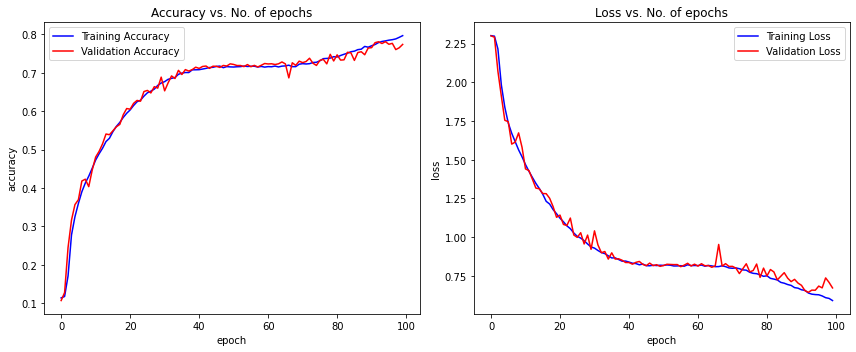

In [49]:
plot_metrics(history_alex4)

In [50]:
model_alex5 = AlexNetModel(num_classes)
model_alex5 = model_alex5.to(device)

In [52]:
opt_alex5 = optim.Adam(model_alex5.parameters(), lr=1e-4, weight_decay=1e-3)
history_alex5, val_acc_alex5 = fit3(model_alex5, train_loader2, valid_loader2, opt_alex5, patience=5)

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.87it/s]


Epoch [1], train_loss: 1.6865, train_acc: 0.3836, val_loss: 1.5190, val_acc: 0.4525


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [2], train_loss: 1.3830, train_acc: 0.5042, val_loss: 1.4689, val_acc: 0.4708


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [3], train_loss: 1.2257, train_acc: 0.5629, val_loss: 1.2591, val_acc: 0.5642


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [4], train_loss: 1.1008, train_acc: 0.6156, val_loss: 1.2102, val_acc: 0.5721


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [5], train_loss: 1.0080, train_acc: 0.6466, val_loss: 0.9548, val_acc: 0.6680


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.94it/s]


Epoch [6], train_loss: 0.9127, train_acc: 0.6816, val_loss: 0.9722, val_acc: 0.6661


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:54<00:00,  2.90it/s]


Epoch [7], train_loss: 0.8645, train_acc: 0.6981, val_loss: 0.8479, val_acc: 0.7070


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.94it/s]


Epoch [8], train_loss: 0.8102, train_acc: 0.7187, val_loss: 0.8070, val_acc: 0.7224


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:56<00:00,  2.85it/s]


Epoch [9], train_loss: 0.7806, train_acc: 0.7279, val_loss: 0.7612, val_acc: 0.7352


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:55<00:00,  2.89it/s]


Epoch [10], train_loss: 0.7405, train_acc: 0.7422, val_loss: 0.7443, val_acc: 0.7481


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.95it/s]


Epoch [11], train_loss: 0.7046, train_acc: 0.7524, val_loss: 0.8004, val_acc: 0.7272


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:53<00:00,  2.93it/s]


Epoch [12], train_loss: 0.6899, train_acc: 0.7611, val_loss: 0.6966, val_acc: 0.7598


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [13], train_loss: 0.6413, train_acc: 0.7786, val_loss: 0.6396, val_acc: 0.7836


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.98it/s]


Epoch [14], train_loss: 0.6278, train_acc: 0.7829, val_loss: 0.6739, val_acc: 0.7692


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:54<00:00,  2.92it/s]


Epoch [15], train_loss: 0.6063, train_acc: 0.7891, val_loss: 0.7299, val_acc: 0.7498


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.97it/s]


Epoch [16], train_loss: 0.5943, train_acc: 0.7932, val_loss: 0.6926, val_acc: 0.7634


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [17], train_loss: 0.5713, train_acc: 0.8014, val_loss: 0.6917, val_acc: 0.7640


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:52<00:00,  2.96it/s]


Epoch [18], train_loss: 0.5558, train_acc: 0.8077, val_loss: 0.5777, val_acc: 0.8043


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [19], train_loss: 0.5271, train_acc: 0.8180, val_loss: 0.5903, val_acc: 0.8031


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [20], train_loss: 0.5202, train_acc: 0.8202, val_loss: 0.5721, val_acc: 0.8051


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  3.00it/s]


Epoch [21], train_loss: 0.4990, train_acc: 0.8277, val_loss: 0.5479, val_acc: 0.8132


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:51<00:00,  2.99it/s]


Epoch [22], train_loss: 0.4922, train_acc: 0.8285, val_loss: 0.5566, val_acc: 0.8150


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [23], train_loss: 0.4725, train_acc: 0.8383, val_loss: 0.5264, val_acc: 0.8181


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [24], train_loss: 0.4584, train_acc: 0.8418, val_loss: 0.5228, val_acc: 0.8208


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [25], train_loss: 0.4381, train_acc: 0.8470, val_loss: 0.5287, val_acc: 0.8247


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [26], train_loss: 0.4266, train_acc: 0.8522, val_loss: 0.4949, val_acc: 0.8359


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [27], train_loss: 0.4130, train_acc: 0.8588, val_loss: 0.5080, val_acc: 0.8231


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [28], train_loss: 0.4033, train_acc: 0.8612, val_loss: 0.5022, val_acc: 0.8303


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [29], train_loss: 0.3885, train_acc: 0.8658, val_loss: 0.5025, val_acc: 0.8327


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.09it/s]


Epoch [30], train_loss: 0.3809, train_acc: 0.8698, val_loss: 0.4737, val_acc: 0.8390


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.10it/s]


Epoch [31], train_loss: 0.3650, train_acc: 0.8749, val_loss: 0.4580, val_acc: 0.8452


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.11it/s]


Epoch [32], train_loss: 0.3586, train_acc: 0.8773, val_loss: 0.4667, val_acc: 0.8402


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [33], train_loss: 0.3461, train_acc: 0.8808, val_loss: 0.4747, val_acc: 0.8412


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [34], train_loss: 0.3343, train_acc: 0.8863, val_loss: 0.4888, val_acc: 0.8396


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [35], train_loss: 0.3234, train_acc: 0.8879, val_loss: 0.4429, val_acc: 0.8559


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [36], train_loss: 0.3157, train_acc: 0.8903, val_loss: 0.4450, val_acc: 0.8493


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [37], train_loss: 0.3083, train_acc: 0.8931, val_loss: 0.4428, val_acc: 0.8514


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [38], train_loss: 0.3040, train_acc: 0.8941, val_loss: 0.4366, val_acc: 0.8548


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.03it/s]


Epoch [39], train_loss: 0.2937, train_acc: 0.8981, val_loss: 0.4284, val_acc: 0.8555


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [40], train_loss: 0.2801, train_acc: 0.9036, val_loss: 0.4335, val_acc: 0.8597


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.10it/s]


Epoch [41], train_loss: 0.2803, train_acc: 0.9037, val_loss: 0.4336, val_acc: 0.8558


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [42], train_loss: 0.2773, train_acc: 0.9044, val_loss: 0.4207, val_acc: 0.8614


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.06it/s]


Epoch [43], train_loss: 0.2653, train_acc: 0.9084, val_loss: 0.4249, val_acc: 0.8579


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [44], train_loss: 0.2632, train_acc: 0.9083, val_loss: 0.4132, val_acc: 0.8632


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.10it/s]


Epoch [45], train_loss: 0.2592, train_acc: 0.9099, val_loss: 0.4192, val_acc: 0.8607


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.05it/s]


Epoch [46], train_loss: 0.2541, train_acc: 0.9125, val_loss: 0.4154, val_acc: 0.8590


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.08it/s]


Epoch [47], train_loss: 0.2534, train_acc: 0.9133, val_loss: 0.4140, val_acc: 0.8671


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:49<00:00,  3.04it/s]


Epoch [48], train_loss: 0.2468, train_acc: 0.9142, val_loss: 0.4151, val_acc: 0.8640


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.03it/s]


Epoch [49], train_loss: 0.2509, train_acc: 0.9125, val_loss: 0.4089, val_acc: 0.8614


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Epoch [50], train_loss: 0.2513, train_acc: 0.9125, val_loss: 0.4164, val_acc: 0.8602


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:47<00:00,  3.09it/s]


Epoch [51], train_loss: 0.2473, train_acc: 0.9145, val_loss: 0.4198, val_acc: 0.8584


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.02it/s]


Epoch [52], train_loss: 0.2491, train_acc: 0.9145, val_loss: 0.4189, val_acc: 0.8638


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:50<00:00,  3.01it/s]


Epoch [53], train_loss: 0.2468, train_acc: 0.9149, val_loss: 0.4153, val_acc: 0.8613


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [01:48<00:00,  3.07it/s]


Early stopping at epoch 54 due to 5 consecutive epochs with no improvement in val_loss.
Final Validation Accuracy: 0.8613


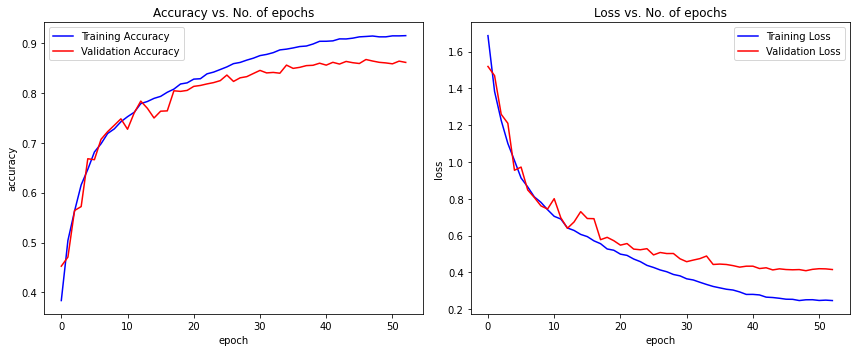

In [53]:
plot_metrics(history_alex5)

## 5. Fit the best model

In [54]:
# Use further data augmentation to load full train set data.
fulltrain_loader = DataLoader(dataset=full_trainset2, batch_size=128, shuffle=True, num_workers=2)
fulltrain_loader = DeviceDataLoader(fulltrain_loader, device)

In [64]:
def train_full(model, full_train_loader, optimizer, epochs=50):
    model.train()  
    scaler = GradScaler()
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    for epoch in range(epochs):
        train_losses = []
        train_accs = []

        for batch in tqdm(full_train_loader):
            with autocast():
                loss, acc = model.training_step(batch)
            train_losses.append(loss.detach())
            train_accs.append(acc)

            scaler.scale(loss).backward() 
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_train_loss = torch.stack(train_losses).mean().item()
        avg_train_acc = torch.stack(train_accs).mean().item()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
        
        scheduler.step()

    print("Final training completed on full training set.")
    return avg_train_acc


In [56]:
model = AlexNetModel(num_classes)
model = model.to(device)

In [57]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [65]:
train_acc = train_full(model, fulltrain_loader, optimizer)

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch [1/50], Train Loss: 1.3357, Train Acc: 0.5229


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:40<00:00,  2.44it/s]


Epoch [2/50], Train Loss: 1.1694, Train Acc: 0.5867


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:44<00:00,  2.38it/s]


Epoch [3/50], Train Loss: 1.0410, Train Acc: 0.6343


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:42<00:00,  2.41it/s]


Epoch [4/50], Train Loss: 0.9309, Train Acc: 0.6751


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:41<00:00,  2.42it/s]


Epoch [5/50], Train Loss: 0.8735, Train Acc: 0.6982


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:44<00:00,  2.38it/s]


Epoch [6/50], Train Loss: 0.8056, Train Acc: 0.7213


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch [7/50], Train Loss: 0.7591, Train Acc: 0.7352


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:46<00:00,  2.34it/s]


Epoch [8/50], Train Loss: 0.7218, Train Acc: 0.7497


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch [9/50], Train Loss: 0.6913, Train Acc: 0.7620


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:49<00:00,  2.30it/s]


Epoch [10/50], Train Loss: 0.6614, Train Acc: 0.7711


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:54<00:00,  2.23it/s]


Epoch [11/50], Train Loss: 0.6373, Train Acc: 0.7790


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:55<00:00,  2.22it/s]


Epoch [12/50], Train Loss: 0.6034, Train Acc: 0.7932


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:43<00:00,  2.39it/s]


Epoch [13/50], Train Loss: 0.5826, Train Acc: 0.7977


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch [14/50], Train Loss: 0.5638, Train Acc: 0.8086


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:53<00:00,  2.25it/s]


Epoch [15/50], Train Loss: 0.5483, Train Acc: 0.8108


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:58<00:00,  2.19it/s]


Epoch [16/50], Train Loss: 0.5318, Train Acc: 0.8158


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:58<00:00,  2.20it/s]


Epoch [17/50], Train Loss: 0.5143, Train Acc: 0.8221


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:04<00:00,  2.12it/s]


Epoch [18/50], Train Loss: 0.4926, Train Acc: 0.8288


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:07<00:00,  2.09it/s]


Epoch [19/50], Train Loss: 0.4806, Train Acc: 0.8347


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:10<00:00,  2.05it/s]


Epoch [20/50], Train Loss: 0.4652, Train Acc: 0.8400


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:25<00:00,  1.90it/s]


Epoch [21/50], Train Loss: 0.4571, Train Acc: 0.8416


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:21<00:00,  1.94it/s]


Epoch [22/50], Train Loss: 0.4377, Train Acc: 0.8488


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:55<00:00,  2.22it/s]


Epoch [23/50], Train Loss: 0.4211, Train Acc: 0.8547


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:56<00:00,  2.22it/s]


Epoch [24/50], Train Loss: 0.4172, Train Acc: 0.8559


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:57<00:00,  2.20it/s]


Epoch [25/50], Train Loss: 0.4017, Train Acc: 0.8625


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:01<00:00,  2.15it/s]


Epoch [26/50], Train Loss: 0.3943, Train Acc: 0.8634


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:56<00:00,  2.22it/s]


Epoch [27/50], Train Loss: 0.3826, Train Acc: 0.8690


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch [28/50], Train Loss: 0.3671, Train Acc: 0.8736


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch [29/50], Train Loss: 0.3573, Train Acc: 0.8769


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [30/50], Train Loss: 0.3449, Train Acc: 0.8811


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:51<00:00,  2.27it/s]


Epoch [31/50], Train Loss: 0.3303, Train Acc: 0.8855


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:46<00:00,  2.34it/s]


Epoch [32/50], Train Loss: 0.3268, Train Acc: 0.8865


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:47<00:00,  2.34it/s]


Epoch [33/50], Train Loss: 0.3137, Train Acc: 0.8907


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:46<00:00,  2.34it/s]


Epoch [34/50], Train Loss: 0.3045, Train Acc: 0.8941


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:47<00:00,  2.34it/s]


Epoch [35/50], Train Loss: 0.2982, Train Acc: 0.8962


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:48<00:00,  2.32it/s]


Epoch [36/50], Train Loss: 0.2837, Train Acc: 0.9004


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [37/50], Train Loss: 0.2773, Train Acc: 0.9033


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:59<00:00,  2.18it/s]


Epoch [38/50], Train Loss: 0.2726, Train Acc: 0.9044


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:53<00:00,  2.25it/s]


Epoch [39/50], Train Loss: 0.2616, Train Acc: 0.9091


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:03<00:00,  2.13it/s]


Epoch [40/50], Train Loss: 0.2536, Train Acc: 0.9117


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:51<00:00,  2.27it/s]


Epoch [41/50], Train Loss: 0.2522, Train Acc: 0.9127


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:54<00:00,  2.25it/s]


Epoch [42/50], Train Loss: 0.2455, Train Acc: 0.9148


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [43/50], Train Loss: 0.2442, Train Acc: 0.9144


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [44/50], Train Loss: 0.2362, Train Acc: 0.9170


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [45/50], Train Loss: 0.2346, Train Acc: 0.9184


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:08<00:00,  2.07it/s]


Epoch [46/50], Train Loss: 0.2305, Train Acc: 0.9208


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:02<00:00,  2.14it/s]


Epoch [47/50], Train Loss: 0.2272, Train Acc: 0.9206


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:03<00:00,  2.13it/s]


Epoch [48/50], Train Loss: 0.2265, Train Acc: 0.9214


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:07<00:00,  2.09it/s]


Epoch [49/50], Train Loss: 0.2267, Train Acc: 0.9229


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [03:07<00:00,  2.08it/s]

Epoch [50/50], Train Loss: 0.2251, Train Acc: 0.9230
Final training completed on full training set.


In [66]:
# Test
model.eval()  
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [76]:
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8926
Test Error Rate: 0.1074


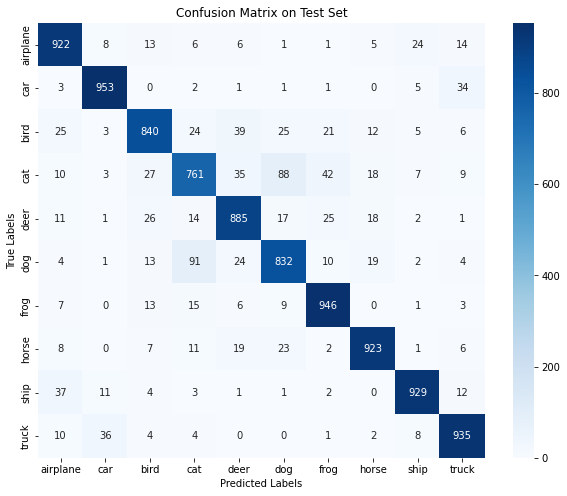

In [67]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

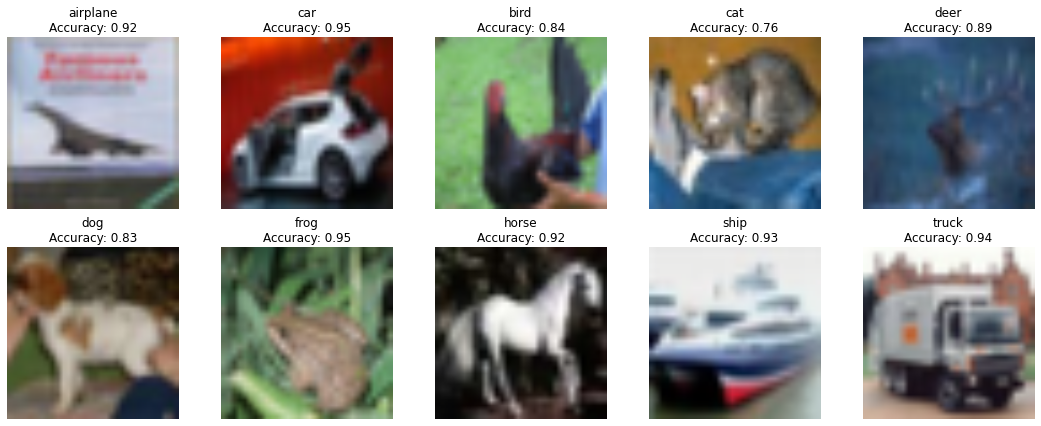

In [73]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, class_name in enumerate(classes):
    for i, (image, label) in enumerate(testset):
        if label == idx:
            image = image.permute(1, 2, 0).numpy()
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2023, 0.1994, 0.2010])
            image = std * image + mean  

            axes[idx].imshow(np.clip(image, 0, 1))
            axes[idx].axis('off')
            axes[idx].set_title(f"{class_name}\nAccuracy: {class_accuracy[idx]:.2f}")
            break  

plt.tight_layout()
plt.show()


In [96]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

    airplane       0.89      0.92      0.91      1000
         car       0.94      0.95      0.95      1000
        bird       0.89      0.84      0.86      1000
         cat       0.82      0.76      0.79      1000
        deer       0.87      0.89      0.88      1000
         dog       0.83      0.83      0.83      1000
        frog       0.90      0.95      0.92      1000
       horse       0.93      0.92      0.92      1000
        ship       0.94      0.93      0.94      1000
       truck       0.91      0.94      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

